### NN models with PyTorch

In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

In [2]:
# Set up IMDB dataset... since the tweets don't give us much to work with

def load_and_preprocess_data(n_samples=1000):
    imdb_df = pd.read_csv("IMDB Dataset.csv")
    
    # Sample data for faster experimentation
    df_positive = imdb_df[imdb_df['sentiment']=='positive'][:n_samples//2]
    df_negative = imdb_df[imdb_df['sentiment']=='negative'][:n_samples//2]
    imdb = pd.concat([df_positive, df_negative])
    
    print(f"Dataset shape: {imdb.shape}")
    
    # Text cleaning
    def clean_text(text):
        # Remove HTML tags
        text = re.sub(r'<.*?>', ' ', text)
        # Remove punctuation and special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    
    imdb['review'] = imdb['review'].apply(clean_text)
    
    # Convert sentiment to binary
    imdb['sentiment'] = imdb['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
    
    return imdb

# Load data
data = load_and_preprocess_data(n_samples=2000)
print(f"Positive samples: {sum(data['sentiment'])}")
print(f"Negative samples: {len(data) - sum(data['sentiment'])}")

Dataset shape: (2000, 2)
Positive samples: 1000
Negative samples: 1000


In [3]:
# Text Tokenization and Vocabulary Building
def build_vocabulary(texts, min_freq=2):
    """
    Build vocabulary from texts
    """
    # Tokenize texts
    all_tokens = []
    for text in texts:
        tokens = word_tokenize(text)
        all_tokens.extend(tokens)
    
    # Count token frequencies
    token_counts = Counter(all_tokens)
    
    # Create vocabulary with special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    
    for token, count in token_counts.items():
        if count >= min_freq:
            vocab[token] = idx
            idx += 1
    
    print(f"Vocabulary size: {len(vocab)}")
    return vocab

def text_to_sequences(texts, vocab, max_length=100):
    """
    Convert texts to sequences of indices
    """
    sequences = []
    for text in texts:
        tokens = word_tokenize(text)
        sequence = [vocab.get(token, vocab['<UNK>']) for token in tokens]
        # Pad or truncate to max_length
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence.extend([vocab['<PAD>']] * (max_length - len(sequence)))
        sequences.append(sequence)
    
    return np.array(sequences)

# Build vocabulary and convert texts to sequences
vocab = build_vocabulary(data['review'])
max_length = 100
sequences = text_to_sequences(data['review'], vocab, max_length)
labels = data['sentiment'].values

print(f"Sequence shape: {sequences.shape}")
print(f"Labels shape: {labels.shape}")

Vocabulary size: 14215
Sequence shape: (2000, 100)
Labels shape: (2000,)


In [4]:
# Base case with default hyperparameters

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cpu


In [5]:
# Load and preprocess IMDB dataset (using the same approach as TensorFlow version)
def load_imdb_data(vocab_size=10000, max_length=200, test_size=0.2):
    """
    Load and preprocess IMDB dataset for PyTorch
    """

    df = pd.read_csv("IMDB Dataset.csv")
    # Convert to the format expected by our models
    texts = df['review'].tolist()
    labels = (df['sentiment'] == 'positive').astype(int).tolist()
    
    # Use our existing vocabulary building function
    vocab = build_vocabulary(texts, min_freq=2)
    
    # Limit vocabulary size
    if len(vocab) > vocab_size:
        # Keep most frequent words
        word_counts = Counter()
        for text in texts:
            tokens = word_tokenize(text.lower())
            word_counts.update(tokens)
        
        # Create limited vocabulary
        most_common = word_counts.most_common(vocab_size - 4)  # Reserve 4 for special tokens
        limited_vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<UNUSED>': 3}
        for i, (word, _) in enumerate(most_common):
            limited_vocab[word] = i + 4
        
        vocab = limited_vocab
    
    # Convert texts to sequences
    sequences = text_to_sequences(texts, vocab, max_length)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        sequences, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    return (X_train, y_train), (X_test, y_test), vocab

# Load data
(X_train, y_train), (X_test, y_test), vocab = load_imdb_data()
vocab_size = len(vocab)
max_length = 200

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {max_length}")


Vocabulary size: 94011
Training samples: 40000
Test samples: 10000
Vocabulary size: 10000
Max sequence length: 200


In [6]:
# Create PyTorch DataLoaders
def create_data_loaders(X_train, y_train, X_test, y_test, batch_size):
    """
    Create PyTorch DataLoaders for training and testing
    """
    # Convert to PyTorch tensors
    X_train_tensor = torch.LongTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.LongTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Create data loaders (default batch size 64)
train_loader, test_loader = create_data_loaders(X_train, y_train, X_test, y_test, 64)
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Training batches: 625
Test batches: 157


In [7]:
# Define PyTorch Models - Base Case with Default Hyperparameters

class RNNModel(nn.Module):
    """
    Simple RNN model for text classification
    Default hyperparameters matching TensorFlow version
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        rnn_out, _ = self.rnn(embedded)  # (batch_size, seq_length, hidden_size)
        # Take the last output
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_size)
        dropped = self.dropout(last_output)
        output = self.fc(dropped)  # (batch_size, num_classes)
        return output

class LSTMModel(nn.Module):
    """
    LSTM model for text classification
    Default hyperparameters matching TensorFlow version
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_length, hidden_size)
        # Take the last output
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        dropped = self.dropout(last_output)
        output = self.fc(dropped)  # (batch_size, num_classes)
        return output

class GRUModel(nn.Module):
    """
    GRU model for text classification
    Default hyperparameters matching TensorFlow version
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_size)
        # Take the last output
        last_output = gru_out[:, -1, :]  # (batch_size, hidden_size)
        dropped = self.dropout(last_output)
        output = self.fc(dropped)  # (batch_size, num_classes)
        return output


In [ ]:
# Training and Evaluation Functions

def train_model(model, train_loader, test_loader, epochs=3, learning_rate=0.001, 
                model_name="Model", loss_function='CrossEntropyLoss', 
                gradient_clip=None, gradient_clip_type='norm', optimizer_type='Adam'):
    """
    Train a PyTorch model and return training history
    
    Args:
        model: PyTorch model to train
        train_loader: training data loader
        test_loader: validation data loader
        epochs: number of training epochs
        learning_rate: learning rate for optimizer
        model_name: name for logging
        loss_function: loss function ('CrossEntropyLoss', 'MSELoss', 'NLLLoss')
        gradient_clip: gradient clipping value (None for no clipping)
        gradient_clip_type: type of gradient clipping ('norm' or 'value')
        optimizer_type: optimizer type ('Adam', 'SGD', 'RMSprop')
    """
    model = model.to(device)
    
    # Select loss function
    if loss_function == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif loss_function == 'MSELoss':
        criterion = nn.MSELoss()
    elif loss_function == 'NLLLoss':
        criterion = nn.NLLLoss()
    else:
        raise ValueError(f"Unsupported loss function: {loss_function}")
    
    # Select optimizer
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_type}")
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    print(f"\nTraining {model_name}...")
    print("-" * 50)
    if gradient_clip is not None:
        print(f"Gradient clipping: {gradient_clip_type} with value {gradient_clip}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            
            # Handle different loss functions
            if loss_function == 'MSELoss':
                # Convert targets to one-hot encoding for MSELoss
                target_one_hot = torch.zeros(target.size(0), 2).to(device)
                target_one_hot.scatter_(1, target.unsqueeze(1), 1)
                loss = criterion(output, target_one_hot)
            elif loss_function == 'NLLLoss':
                # Apply log_softmax for NLLLoss
                output = F.log_softmax(output, dim=1)
                loss = criterion(output, target)
            else:  # CrossEntropyLoss
                loss = criterion(output, target)
            
            loss.backward()

             # Apply gradient clipping if specified
            if gradient_clip is not None:
                if gradient_clip_type == 'norm':
                    # Clip gradients by norm (L2 norm)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                elif gradient_clip_type == 'value':
                    # Clip gradients by value (element-wise)
                    torch.nn.utils.clip_grad_value_(model.parameters(), gradient_clip)
                else:
                    raise ValueError(f"Unsupported gradient_clip_type: {gradient_clip_type}")
                
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                
                if loss_function == 'MSELoss':
                    target_one_hot = torch.zeros(target.size(0), 2).to(device)
                    target_one_hot.scatter_(1, target.unsqueeze(1), 1)
                    loss = criterion(output, target_one_hot)
                elif loss_function == 'NLLLoss':
                    output_log_probs = F.log_softmax(output, dim=1)
                    loss = criterion(output_log_probs, target)
                else:  # CrossEntropyLoss
                    loss = criterion(output, target)
                
                val_loss += loss.item()
                
                if loss_function == 'NLLLoss':
                    _, predicted = torch.max(output_log_probs, 1)
                else:
                    _, predicted = torch.max(output, 1)
                    
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate validation metrics
        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total
        
        # Store metrics
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'final_val_accuracy': val_accuracies[-1]
    }

def evaluate_model(model, test_loader, model_name="Model", use_cached=False, cached_predictions=None, cached_targets=None):
    """
    Evaluate model and return detailed metrics
    
    Args:
        model: PyTorch model (ignored if use_cached=True)
        test_loader: DataLoader for test data (ignored if use_cached=True)
        model_name: Name of the model
        use_cached: If True, use cached predictions and targets instead of running model
        cached_predictions: List/array of cached predictions
        cached_targets: List/array of cached targets
    """
    if use_cached:
        if cached_predictions is None or cached_targets is None:
            raise ValueError("cached_predictions and cached_targets must be provided when use_cached=True")
        all_predictions = cached_predictions
        all_targets = cached_targets
    else:
        model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1_weighted = f1_score(all_targets, all_predictions, average='weighted')
    f1_micro = f1_score(all_targets, all_predictions, average='micro')
    f1_macro = f1_score(all_targets, all_predictions, average='macro')
    
    print(f"\n{model_name} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1_weighted:.4f}")
    print(f"F1-Score (micro): {f1_micro:.4f}")
    print(f"F1-Score (macro): {f1_macro:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1_weighted,  # Keep for backward compatibility
        'f1_weighted': f1_weighted,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'predictions': all_predictions,
        'targets': all_targets
    }


In [10]:
# Train and Evaluate RNN Model
print("=" * 60)
print("TRAINING RNN MODEL (Base Case - Default Hyperparameters)")
print("=" * 60)

# Create RNN model with default hyperparameters
rnn_model = RNNModel(vocab_size=vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0)

# Train the model
rnn_history = train_model(rnn_model, train_loader, test_loader, epochs=3, learning_rate=0.001, model_name="RNN")

# Evaluate the model
rnn_results = evaluate_model(rnn_model, test_loader, "RNN")


TRAINING RNN MODEL (Base Case - Default Hyperparameters)

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6973, Train Acc: 50.73%
  Val Loss: 0.6947, Val Acc: 51.11%
Epoch 2/3:
  Train Loss: 0.6866, Train Acc: 53.72%
  Val Loss: 0.7077, Val Acc: 51.14%
Epoch 3/3:
  Train Loss: 0.6855, Train Acc: 54.40%
  Val Loss: 0.6934, Val Acc: 52.47%

RNN Evaluation Results:
Accuracy: 0.5247
Precision (weighted): 0.5345
Recall (weighted): 0.5247
F1-Score (weighted): 0.4885
F1-Score (micro): 0.5247
F1-Score (macro): 0.4885


In [11]:
# Train and Evaluate LSTM Model
print("=" * 60)
print("TRAINING LSTM MODEL (Base Case - Default Hyperparameters)")
print("=" * 60)

# Create LSTM model with default hyperparameters
lstm_model = LSTMModel(vocab_size=vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0)

# Train the model
lstm_history = train_model(lstm_model, train_loader, test_loader, epochs=3, learning_rate=0.001, model_name="LSTM")

# Evaluate the model
lstm_results = evaluate_model(lstm_model, test_loader, "LSTM")


TRAINING LSTM MODEL (Base Case - Default Hyperparameters)

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6919, Train Acc: 51.79%
  Val Loss: 0.6738, Val Acc: 57.21%
Epoch 2/3:
  Train Loss: 0.6705, Train Acc: 58.34%
  Val Loss: 0.6095, Val Acc: 68.90%
Epoch 3/3:
  Train Loss: 0.4478, Train Acc: 79.75%
  Val Loss: 0.3642, Val Acc: 83.72%

LSTM Evaluation Results:
Accuracy: 0.8372
Precision (weighted): 0.8379
Recall (weighted): 0.8372
F1-Score (weighted): 0.8371
F1-Score (micro): 0.8372
F1-Score (macro): 0.8371


In [12]:
# Train and Evaluate GRU Model
print("=" * 60)
print("TRAINING GRU MODEL (Base Case - Default Hyperparameters)")
print("=" * 60)

# Create GRU model with default hyperparameters
gru_model = GRUModel(vocab_size=vocab_size, embedding_dim=128, hidden_size=64, num_classes=2, dropout=0.0)

# Train the model
gru_history = train_model(gru_model, train_loader, test_loader, epochs=3, learning_rate=0.001, model_name="GRU")

# Evaluate the model
gru_results = evaluate_model(gru_model, test_loader, "GRU")


TRAINING GRU MODEL (Base Case - Default Hyperparameters)

Training GRU...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6820, Train Acc: 54.91%
  Val Loss: 0.6233, Val Acc: 65.56%
Epoch 2/3:
  Train Loss: 0.5204, Train Acc: 74.18%
  Val Loss: 0.3931, Val Acc: 82.62%
Epoch 3/3:
  Train Loss: 0.3307, Train Acc: 85.71%
  Val Loss: 0.3335, Val Acc: 85.24%

GRU Evaluation Results:
Accuracy: 0.8524
Precision (weighted): 0.8527
Recall (weighted): 0.8524
F1-Score (weighted): 0.8524
F1-Score (micro): 0.8524
F1-Score (macro): 0.8524


# Visualisation Functions

### Compare Models

In [13]:
def plot_model_comparison(model_results, model_histories, hyperparams, experiment_name="Experiment"):
    """
    Create comprehensive visualizations for model comparison
    
    Args:
        model_results: dict with keys as model names and values as result dicts
        model_histories: dict with keys as model names and values as history dicts
        hyperparams: dict containing hyperparameter values used
        experiment_name: string name for the experiment
    """
    print("=" * 60)
    print(f"{experiment_name.upper()} - MODEL COMPARISON RESULTS")
    print("=" * 60)
    
    # Create comparison DataFrame
    comparison_data = []
    for model_name, results in model_results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score (Weighted)': results.get('f1_weighted', results.get('f1', 0)),
            'F1-Score (Micro)': results.get('f1_micro', 0),
            'F1-Score (Macro)': results.get('f1_macro', 0)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\nPerformance Comparison:")
    print(comparison_df.round(4))
    
    # Plot training curves
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Training/Validation Loss
    axes[0, 0].set_title('Training and Validation Loss')
    for model_name, history in model_histories.items():
        axes[0, 0].plot(history['train_losses'], label=f'{model_name} Train', linestyle='--')
        axes[0, 0].plot(history['val_losses'], label=f'{model_name} Val', linestyle='-')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Training/Validation Accuracy
    axes[0, 1].set_title('Training and Validation Accuracy')
    for model_name, history in model_histories.items():
        axes[0, 1].plot(history['train_accuracies'], label=f'{model_name} Train', linestyle='--')
        axes[0, 1].plot(history['val_accuracies'], label=f'{model_name} Val', linestyle='-')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Metrics Comparison Bar Chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score (Weighted)', 'F1-Score (Micro)', 'F1-Score (Macro)']
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, (model_name, results) in enumerate(model_results.items()):
        values = [
            results['accuracy'],
            results['precision'],
            results['recall'],
            results.get('f1_weighted', results.get('f1', 0)),
            results.get('f1_micro', 0),
            results.get('f1_macro', 0)
        ]
        axes[0, 2].bar(x + i*width, values, width, label=model_name, alpha=0.8)
    
    axes[0, 2].set_title('Metrics Comparison')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_xticks(x + width)
    axes[0, 2].set_xticklabels(metrics, rotation=45, ha='right')
    axes[0, 2].legend()
    axes[0, 2].grid(True, axis='y')
    axes[0, 2].set_ylim([0, 1])
    
    # Confusion Matrices
    for idx, (model_name, results) in enumerate(model_results.items()):
        row = 1
        col = idx if idx < 3 else 2
        if idx >= 3:
            break
            
        cm = confusion_matrix(results['targets'], results['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col], cbar=False)
        axes[row, col].set_title(f'{model_name} Confusion Matrix')
        axes[row, col].set_ylabel('True Label')
        axes[row, col].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Print best model
    print("=" * 60)
    best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
    best_accuracy = comparison_df['Accuracy'].max()
    print(f"Best performing model: {best_model}")
    print(f"Highest accuracy: {best_accuracy:.4f}")
    
    return comparison_df

### Compare Hyperparameters

In [15]:
def run_hyperparameter_experiment(embedding_dim=128, hidden_size=64, dropout=0.0, 
                                 learning_rate=0.001, epochs=3, batch_size=64, 
                                 experiment_name="Experiment", plot_results=True,
                                 loss_function='CrossEntropyLoss', gradient_clip=None,
                                 gradient_clip_type='norm', optimizer_type='Adam'):
    """
    Run a complete experiment with specified hyperparameters (supports lists)
    
    Args:
        embedding_dim: embedding dimension (int or list)
        hidden_size: hidden layer size for RNN/LSTM/GRU (int or list)
        dropout: dropout rate (float or list)
        learning_rate: learning rate for optimizer (float or list)
        epochs: number of training epochs (int or list)
        batch_size: batch size for training (int or list)
        loss_function: loss function ('CrossEntropyLoss', 'MSELoss', 'NLLLoss')
        gradient_clip: gradient clipping value (None for no clipping)
        gradient_clip_type: type of gradient clipping ('norm' or 'value')
        optimizer_type: optimizer type ('Adam', 'SGD', 'RMSprop')
        experiment_name: name for this experiment (str or list)
        plot_results: whether to generate plots (bool)
    
    Returns:
        dict: nested dictionary with experiment results
        Structure: {experiment_name: {model_name: {results, history, hyperparams}}}
    """
    # Convert single values to lists for uniform processing
    def to_list(x):
        if x is None:
            return [None]
        return x if isinstance(x, list) else [x]
    
    embedding_dims = to_list(embedding_dim)
    hidden_sizes = to_list(hidden_size)
    dropouts = to_list(dropout)
    learning_rates = to_list(learning_rate)
    epochs_list = to_list(epochs)
    batch_sizes = to_list(batch_size)
    experiment_names = to_list(experiment_name)
    loss_functions = to_list(loss_function)
    gradient_clips = to_list(gradient_clip)
    gradient_clip_types = to_list(gradient_clip_type)
    optimizer_types = to_list(optimizer_type)
    
    # Generate all combinations
    from itertools import product
    
    all_experiments = {}
    
    for i, (emb_dim, hid_size, drop, lr, ep, batch, exp_name, loss_func, grad_clip, clip_type, opt_type) in enumerate(
        product(embedding_dims, hidden_sizes, dropouts, learning_rates, 
                epochs_list, batch_sizes, experiment_names, loss_functions,
                gradient_clips, gradient_clip_types, optimizer_types)):
        
        # Create unique experiment name if multiple parameters are varied
        if len(embedding_dims) > 1 or len(hidden_sizes) > 1 or len(dropouts) > 1 or \
           len(learning_rates) > 1 or len(epochs_list) > 1 or len(batch_sizes) > 1 or \
           len(loss_functions) > 1 or len(gradient_clips) > 1 or len(gradient_clip_types) > 1 or \
           len(optimizer_types) > 1:
            clip_suffix = f"_clip{grad_clip}_{clip_type}" if grad_clip is not None else "_noClip"
            exp_name = f"{exp_name}_emb{emb_dim}_hid{hid_size}_drop{drop}_lr{lr}_ep{ep}_bs{batch}_loss{loss_func}{clip_suffix}_opt{opt_type}"
        
        print(f"\n{'='*80}")
        print(f"RUNNING EXPERIMENT: {exp_name.upper()}")
        print(f"{'='*80}")
        
        # Create new data loaders with specified batch size
        train_loader, test_loader = create_data_loaders(X_train, y_train, X_test, y_test, batch_size=batch)
        
        # Initialize models with specified hyperparameters
        models = {
            'RNN': RNNModel(vocab_size=vocab_size, embedding_dim=emb_dim, 
                           hidden_size=hid_size, dropout=drop),
            'LSTM': LSTMModel(vocab_size=vocab_size, embedding_dim=emb_dim, 
                             hidden_size=hid_size, dropout=drop),
            'GRU': GRUModel(vocab_size=vocab_size, embedding_dim=emb_dim, 
                           hidden_size=hid_size, dropout=drop)
        }
        
        # Train and evaluate all models
        model_results = {}
        model_histories = {}
        
        for model_name, model in models.items():
            print(f"\nTraining {model_name}...")
            history = train_model(model, train_loader, test_loader, 
                        epochs=ep, learning_rate=lr, 
                        model_name=model_name,
                        loss_function=loss_func,
                        gradient_clip=grad_clip,
                        gradient_clip_type=clip_type,
                        optimizer_type=opt_type)
            results = evaluate_model(model, test_loader, model_name)
            
            model_results[model_name] = results
            model_histories[model_name] = history
        
        # Create hyperparameters dict
        hyperparams = {
            'Embedding dimension': emb_dim,
            'Hidden size': hid_size,
            'Dropout': drop,
            'Learning rate': lr,
            'Epochs': ep,
            'Batch size': batch,
            'Loss function': loss_func,
            'Gradient clip': grad_clip,
            'Gradient clip type': clip_type,
            'Optimizer': opt_type
        }
        
        # Store experiment results
        all_experiments[exp_name] = {
            'model_results': model_results,
            'model_histories': model_histories,
            'hyperparams': hyperparams
        }
        
        # Generate visualizations if requested and only for single experiments
        if plot_results and len(all_experiments) == 1:
            comparison_df = plot_model_comparison(
                model_results=model_results,
                model_histories=model_histories,
                hyperparams=hyperparams,
                experiment_name=exp_name
            )
            all_experiments[exp_name]['comparison_df'] = comparison_df
    
    return all_experiments

def run_batch_experiments(experiment_configs, plot_individual=False):
    """
    Run multiple experiments with different configurations
    
    Args:
        experiment_configs: list of dicts, each containing hyperparameter configs
        plot_individual: whether to plot individual experiments
    
    Returns:
        dict: nested dictionary with all experiment results
    """
    all_results = {}
    
    for i, config in enumerate(experiment_configs):
        print(f"\n{'='*100}")
        print(f"BATCH EXPERIMENT {i+1}/{len(experiment_configs)}")
        print(f"{'='*100}")
        
        # Set default experiment name if not provided
        if 'experiment_name' not in config:
            config['experiment_name'] = f"Experiment_{i+1}"
        
        # Run experiment
        experiment_results = run_hyperparameter_experiment(
            plot_results=plot_individual,
            **config
        )
        
        # Merge results
        all_results.update(experiment_results)
    
    return all_results

def analyze_batch_results(all_results, metric='Accuracy'):
    """
    Analyze and visualize results from batch experiments
    
    Args:
        all_results: results from run_batch_experiments
        metric: metric to analyze (default: 'Accuracy')
    """
    print(f"\n{'='*80}")
    print(f"BATCH EXPERIMENT ANALYSIS - {metric.upper()}")
    print(f"{'='*80}")
    
    # Create comprehensive comparison
    comparison_data = []
    experiment_summaries = {}
    
    for exp_name, exp_data in all_results.items():
        # Create comparison dataframe for this experiment
        exp_comparison = []
        for model_name, results in exp_data['model_results'].items():
            exp_comparison.append({
                'Model': model_name,
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1-Score (Weighted)': results.get('f1_weighted', results.get('f1', 0)),
                'F1-Score (Micro)': results.get('f1_micro', 0),
                'F1-Score (Macro)': results.get('f1_macro', 0)
            })
        
        exp_df = pd.DataFrame(exp_comparison)
        exp_data['comparison_df'] = exp_df
        
        # Store experiment summary
        best_model = exp_df.loc[exp_df[metric].idxmax()]
        experiment_summaries[exp_name] = {
            'best_model': best_model['Model'],
            'best_score': best_model[metric],
            'hyperparams': exp_data['hyperparams']
    }
    
    # Add to overall comparison
    for _, row in exp_df.iterrows():
        comparison_data.append({
            'Experiment': exp_name,
            'Model': row['Model'],
            'Accuracy': row['Accuracy'],
            'Precision': row['Precision'],
            'Recall': row['Recall'],
            'F1-Score (Weighted)': row['F1-Score (Weighted)'],
            'F1-Score (Micro)': row['F1-Score (Micro)'],
            'F1-Score (Macro)': row['F1-Score (Macro)']
        })
    
    # Create overall comparison dataframe
    overall_df = pd.DataFrame(comparison_data)
    
    # Print experiment summaries
    print("\nExperiment Summaries:")
    print("-" * 80)
    for exp_name, summary in experiment_summaries.items():
        print(f"{exp_name}:")
        print(f"  Best Model: {summary['best_model']} ({summary['best_score']:.4f})")
        print(f"  Hyperparams: {summary['hyperparams']}")
        print()
    
    # Create visualizations
    plot_hyperparameter_comparison(
        {name: data['comparison_df'] for name, data in all_results.items()}, 
        metric=metric
    )
    
    return overall_df, experiment_summaries

    print("\n" + "="*80)
print("USAGE SUMMARY")
print("="*80)
print("1. Single experiment with lists: run_hyperparameter_experiment()")
print("   - Pass lists to test multiple values")
print("   - All combinations will be tested")
print("   - Returns nested dictionary with all results")
print()
print("2. Batch experiments: run_batch_experiments()")
print("   - Pass list of configuration dictionaries")
print("   - Each config can have different hyperparameters")
print("   - Returns consolidated results")
print()
print("3. Analysis: analyze_batch_results()")
print("   - Takes results from batch experiments")
print("   - Creates comprehensive visualizations")
print("   - Returns summary statistics")
print()
print("4. Data structure:")
print("   {experiment_name: {model_results: {...}, model_histories: {...}, hyperparams: {...}}}")


USAGE SUMMARY
1. Single experiment with lists: run_hyperparameter_experiment()
   - Pass lists to test multiple values
   - All combinations will be tested
   - Returns nested dictionary with all results

2. Batch experiments: run_batch_experiments()
   - Pass list of configuration dictionaries
   - Each config can have different hyperparameters
   - Returns consolidated results

3. Analysis: analyze_batch_results()
   - Takes results from batch experiments
   - Creates comprehensive visualizations
   - Returns summary statistics

4. Data structure:
   {experiment_name: {model_results: {...}, model_histories: {...}, hyperparams: {...}}}


### Plot effects of hyperparameter

In [29]:
    def get_metric_value(results, metric):
        """Helper to safely get metric value, handling name variations"""
        metric_lower = metric.lower().replace('-', '_').replace(' ', '_')
        
        # Direct lookup
        if metric_lower in results:
            return results[metric_lower]
        
        # Mapping for common variations
        metric_map = {
            'f1': 'f1',
            'f1_score': 'f1',
            'f1-weighted': 'f1_weighted',
            'f1_weighted': 'f1_weighted',
            'f1-micro': 'f1_micro',
            'f1_micro': 'f1_micro',
            'f1-macro': 'f1_macro',
            'f1_macro': 'f1_macro',
        }
        
        return results.get(metric_map.get(metric_lower, metric_lower), 0)

In [ ]:
def plot_hyperparameter_effect(all_results, plot_hp, metric='Accuracy', 
                              plot_type='line', figsize=(15, 10)):
    """
    Plot the effect of a specific hyperparameter across all experiments
    
    Args:
        all_results: nested dictionary from run_hyperparameter_experiment or run_batch_experiments
        plot_hp: hyperparameter to plot (e.g., 'lr', 'hidden_size', 'dropout', 'embedding_dim')
        metric: metric to plot (default: 'Accuracy')
        plot_type: 'line' or 'bar' (default: 'line')
        figsize: figure size tuple (default: (15, 10))
    """
    # Map plot_hp to actual hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate',
        'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size',
        'hid': 'Hidden size',
        'dropout': 'Dropout',
        'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension',
        'emb': 'Embedding dimension',
        'epochs': 'Epochs',
        'ep': 'Epochs',
        'batch_size': 'Batch size',
        'bs': 'Batch size'
    }
    
    actual_hp_name = hp_mapping.get(plot_hp.lower(), plot_hp)
    
    # Extract data for plotting
    plot_data = []
    
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp_value = hyperparams.get(actual_hp_name, 'Unknown')
        
        for model_name, results in exp_data['model_results'].items():
            plot_data.append({
                'Experiment': exp_name,
                'Model': model_name,
                'Hyperparameter': hp_value,
                'Metric': get_metric_value(results, metric),
                'All_Params': hyperparams
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Get unique values of the hyperparameter and other parameters
    unique_hp_values = sorted(plot_df['Hyperparameter'].unique())
    unique_models = plot_df['Model'].unique()
    
    # Define colors and markers
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_hp_values)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # Create color and marker mappings
    hp_color_map = {val: colors[i] for i, val in enumerate(unique_hp_values)}
    model_marker_map = {model: markers[i % len(markers)] for i, model in enumerate(unique_models)}
    
    # Check if we need to group by other hyperparameters
    other_params = [k for k in hyperparams.keys() if k != actual_hp_name]
    other_params_values = plot_df['All_Params'].apply(lambda x: tuple(x[k] for k in other_params)).unique()
    
    # Create subplots if we have multiple combinations of other parameters
    if len(other_params_values) > 1:
        n_combinations = len(other_params_values)
        n_cols = min(3, n_combinations)
        n_rows = (n_combinations + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
        if n_combinations == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        
        axes = axes.flatten()
        
        for i, other_combo in enumerate(other_params_values):
            ax = axes[i]
            
            # Filter data for this combination
            combo_data = plot_df[plot_df['All_Params'].apply(
                lambda x: tuple(x[k] for k in other_params) == other_combo
            )]
            
            # Create plot
            for model in unique_models:
                model_data = combo_data[combo_data['Model'] == model]
                if len(model_data) > 0:
                    if plot_type == 'line':
                        ax.plot(model_data['Hyperparameter'], model_data['Metric'], 
                               marker=model_marker_map[model], 
                               color=model_data['Hyperparameter'].map(hp_color_map).iloc[0],
                               label=f'{model}', linewidth=2, markersize=8)
                    else:  # bar plot
                        x_pos = np.arange(len(model_data))
                        ax.bar(x_pos, model_data['Metric'], 
                              color=model_data['Hyperparameter'].map(hp_color_map).iloc[0],
                              alpha=0.7, label=f'{model}')
                        ax.set_xticks(x_pos)
                        ax.set_xticklabels(model_data['Hyperparameter'], rotation=45)
            
            ax.set_title(f'Other params: {dict(zip(other_params, other_combo))}')
            ax.set_xlabel(actual_hp_name)
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for i in range(n_combinations, len(axes)):
            axes[i].set_visible(False)
            
    else:
        # Single plot
        fig, ax = plt.subplots(figsize=figsize)
        
        for model in unique_models:
            model_data = plot_df[plot_df['Model'] == model]
            if len(model_data) > 0:
                if plot_type == 'line':
                    ax.plot(model_data['Hyperparameter'], model_data['Metric'], 
                           marker=model_marker_map[model], 
                           color=model_data['Hyperparameter'].map(hp_color_map).iloc[0],
                           label=f'{model}', linewidth=2, markersize=8)
                else:  # bar plot
                    x_pos = np.arange(len(model_data))
                    ax.bar(x_pos, model_data['Metric'], 
                          color=model_data['Hyperparameter'].map(hp_color_map).iloc[0],
                          alpha=0.7, label=f'{model}')
                    ax.set_xticks(x_pos)
                    ax.set_xticklabels(model_data['Hyperparameter'], rotation=45)
        
        ax.set_title(f'{metric} vs {actual_hp_name}')
        ax.set_xlabel(actual_hp_name)
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{metric} Summary for {actual_hp_name}:")
    print("-" * 50)
    summary = plot_df.groupby(['Hyperparameter', 'Model'])['Metric'].agg(['mean', 'std', 'min', 'max']).round(4)
    print(summary)
    
    return plot_df

def plot_hyperparameter_heatmap(all_results, plot_hp1, plot_hp2, metric='Accuracy'):
    """
    Create a heatmap showing the interaction between two hyperparameters
    
    Args:
        all_results: nested dictionary from experiments
        plot_hp1: first hyperparameter (e.g., 'lr', 'hidden_size')
        plot_hp2: second hyperparameter (e.g., 'dropout', 'embedding_dim')
        metric: metric to plot (default: 'Accuracy')
    """
    # Map hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate', 'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size', 'hid': 'Hidden size',
        'dropout': 'Dropout', 'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension', 'emb': 'Embedding dimension',
        'epochs': 'Epochs', 'ep': 'Epochs',
        'batch_size': 'Batch size', 'bs': 'Batch size'
    }
    
    hp1_name = hp_mapping.get(plot_hp1.lower(), plot_hp1)
    hp2_name = hp_mapping.get(plot_hp2.lower(), plot_hp2)
    
    # Extract data
    heatmap_data = []
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp1_value = hyperparams.get(hp1_name, 'Unknown')
        hp2_value = hyperparams.get(hp2_name, 'Unknown')
        
        for model_name, results in exp_data['model_results'].items():
            heatmap_data.append({
                'Model': model_name,
                'HP1': hp1_value,
                'HP2': hp2_value,
                'Metric': get_metric_value(results, metric)
            })
    
    heatmap_df = pd.DataFrame(heatmap_data)
    
    # Create heatmap for each model
    unique_models = heatmap_df['Model'].unique()
    n_models = len(unique_models)
    
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 1:
        axes = [axes]
    
    for i, model in enumerate(unique_models):
        model_data = heatmap_df[heatmap_df['Model'] == model]
        
        # Create pivot table
        pivot_table = model_data.pivot_table(
            values='Metric', 
            index='HP2', 
            columns='HP1', 
            aggfunc='mean'
        )
        
        # Create heatmap
        sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
                   ax=axes[i], cbar_kws={'label': metric})
        axes[i].set_title(f'{model} - {metric} Heatmap')
        axes[i].set_xlabel(hp1_name)
        axes[i].set_ylabel(hp2_name)
    
    plt.tight_layout()
    plt.show()
    
    return heatmap_df

def plot_model_comparison_by_hp(all_results, plot_hp, metric='Accuracy'):
    """
    Compare model performance across different hyperparameter values
    Uses colors for models
    """
    # Map hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate', 'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size', 'hid': 'Hidden size',
        'dropout': 'Dropout', 'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension', 'emb': 'Embedding dimension',
        'epochs': 'Epochs', 'ep': 'Epochs',
        'batch_size': 'Batch size', 'bs': 'Batch size',
        'loss_function': 'Loss function', 'loss': 'Loss function',
        'gradient_clip': 'Gradient clip', 'clip': 'Gradient clip',
        'gradient_clip_type': 'Gradient clip type', 'clip_type': 'Gradient clip type',
        'optimizer_type': 'Optimizer', 'optimizer': 'Optimizer'
    }
    
    actual_hp_name = hp_mapping.get(plot_hp.lower(), plot_hp)
    
    # Extract data
    comparison_data = []
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp_value = hyperparams.get(actual_hp_name, 'Unknown')
        
        # Convert list values to strings to avoid pandas categorical issues
        if isinstance(hp_value, list):
            hp_value = str(hp_value)
        
        for model_name, results in exp_data['model_results'].items():
            comparison_data.append({
                'Model': model_name,
                'Hyperparameter': hp_value,
                'Metric': get_metric_value(results, metric)
            })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Handle duplicate entries by aggregating (taking mean of duplicate values)
    comp_df_agg = comp_df.groupby(['Hyperparameter', 'Model'])['Metric'].mean().reset_index()
    
    # Define colors for models
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    unique_models = comp_df_agg['Model'].unique()
    model_color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(unique_models)}
    
    # Create grouped bar plot
    plt.figure(figsize=(12, 6))
    
    # Pivot for grouped bar plot
    pivot_df = comp_df_agg.pivot(index='Hyperparameter', columns='Model', values='Metric')
    
    # Create bar plot with custom colors
    ax = pivot_df.plot(kind='bar', figsize=(12, 6), width=0.8, 
                      color=[model_color_map[model] for model in pivot_df.columns])
    plt.title(f'{metric} by {actual_hp_name} and Model')
    plt.xlabel(actual_hp_name)
    plt.ylabel(metric)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print(f"\nDetailed {metric} Comparison by {actual_hp_name}:")
    print("-" * 60)
    print(pivot_df.round(4))
    
    return comp_df_agg

print("\n" + "="*80)
print("ENHANCED PLOTTING FUNCTIONS SUMMARY")
print("="*80)
print("1. plot_hyperparameter_effect(all_results, plot_hp, metric, plot_type)")
print("   - Plots effect of specific hyperparameter on chosen metric")
print("   - Supports 'line' and 'bar' plot types")
print("   - Automatically handles multiple combinations of other parameters")
print("   - Uses different colors for hyperparameter values, different markers for models")
print()
print("2. plot_hyperparameter_heatmap(all_results, plot_hp1, plot_hp2, metric)")
print("   - Creates heatmap showing interaction between two hyperparameters")
print("   - Separate heatmap for each model")
print("   - Useful for finding optimal combinations")
print()
print("3. plot_model_comparison_by_hp(all_results, plot_hp, metric)")
print("   - Compares model performance across hyperparameter values")
print("   - Grouped bar chart format")
print("   - Shows detailed comparison table")
print()
print("Supported hyperparameter shortcuts:")
print("  - 'lr' or 'learning_rate' → Learning rate")
print("  - 'hidden_size' or 'hid' → Hidden size")
print("  - 'dropout' or 'drop' → Dropout")
print("  - 'embedding_dim' or 'emb' → Embedding dimension")
print("  - 'epochs' or 'ep' → Epochs")
print("  - 'batch_size' or 'bs' → Batch size")
print("  - 'loss_function' or 'loss' → Loss function")
print("  - 'gradient_clip' or 'clip' → Gradient clip")
print("  - 'gradient_clip_type' or 'clip_type' → Gradient clip type")
print("  - 'optimizer_type' or 'optimizer' → Optimizer")

# # Usage Examples for Enhanced Plotting Functions

# # Example 1: Plot the effect of learning rate on accuracy
# print("Example 1: Plotting learning rate effect on accuracy")
# plot_hyperparameter_effect(hidden_lr_experiments, plot_hp='lr', metric='Accuracy', plot_type='line')

# # Example 2: Plot the effect of hidden size on F1-score
# print("\nExample 2: Plotting hidden size effect on F1-score")
# plot_hyperparameter_effect(hidden_lr_experiments, plot_hp='hidden_size', metric='F1-Score', plot_type='bar')

# # Example 3: Create heatmap showing interaction between learning rate and hidden size
# print("\nExample 3: Heatmap of learning rate vs hidden size interaction")
# plot_hyperparameter_heatmap(hidden_lr_experiments, plot_hp1='lr', plot_hp2='hidden_size', metric='Accuracy')

# # Example 4: Compare models across different hyperparameter values
# print("\nExample 4: Model comparison across learning rates")
# plot_model_comparison_by_hp(hidden_lr_experiments, plot_hp='lr', metric='Accuracy')

# # Example 5: Using with batch results
# print("\nExample 5: Using with batch experiment results")
# # This would work with batch_results from the previous examples
# # plot_hyperparameter_effect(batch_results, plot_hp='lr', metric='Accuracy')


ENHANCED PLOTTING FUNCTIONS SUMMARY
1. plot_hyperparameter_effect(all_results, plot_hp, metric, plot_type)
   - Plots effect of specific hyperparameter on chosen metric
   - Supports 'line' and 'bar' plot types
   - Automatically handles multiple combinations of other parameters
   - Uses different colors for hyperparameter values, different markers for models

2. plot_hyperparameter_heatmap(all_results, plot_hp1, plot_hp2, metric)
   - Creates heatmap showing interaction between two hyperparameters
   - Separate heatmap for each model
   - Useful for finding optimal combinations

3. plot_model_comparison_by_hp(all_results, plot_hp, metric)
   - Compares model performance across hyperparameter values
   - Grouped bar chart format
   - Shows detailed comparison table

Supported hyperparameter shortcuts:
  - 'lr' or 'learning_rate' → Learning rate
  - 'hidden_size' or 'hid' → Hidden size
  - 'dropout' or 'drop' → Dropout
  - 'embedding_dim' or 'emb' → Embedding dimension
  - 'epochs' or

In [ ]:
# Updated plotting functions with colors for models and markers for hyperparameters

def plot_hyperparameter_effect(all_results, plot_hp, metric='Accuracy', 
                                      plot_type='line', figsize=(15, 10)):
    """
    Plot the effect of a specific hyperparameter across all experiments
    Uses colors for models and markers for hyperparameter values
    """
    # Map plot_hp to actual hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate', 'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size', 'hid': 'Hidden size',
        'dropout': 'Dropout', 'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension', 'emb': 'Embedding dimension',
        'epochs': 'Epochs', 'ep': 'Epochs',
        'batch_size': 'Batch size', 'bs': 'Batch size',
        'loss_function': 'Loss function', 'loss': 'Loss function',
        'gradient_clip': 'Gradient clip', 'clip': 'Gradient clip',
        'gradient_clip_type': 'Gradient clip type', 'clip_type': 'Gradient clip type',
        'optimizer_type': 'Optimizer', 'optimizer': 'Optimizer'
    }
    
    actual_hp_name = hp_mapping.get(plot_hp.lower(), plot_hp)
    
    # Extract data for plotting
    plot_data = []
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp_value = hyperparams.get(actual_hp_name, 'Unknown')
        
        for model_name, results in exp_data['model_results'].items():
            plot_data.append({
                'Experiment': exp_name,
                'Model': model_name,
                'Hyperparameter': hp_value,
                'Metric': get_metric_value(results, metric),
                'All_Params': hyperparams
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Get unique values
    unique_hp_values = sorted(plot_df['Hyperparameter'].unique())
    unique_models = plot_df['Model'].unique()
    
    # Define colors for models and markers for hyperparameter values
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'X', 'P']
    
    # Create mappings
    model_color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(unique_models)}
    hp_marker_map = {val: markers[i % len(markers)] for i, val in enumerate(unique_hp_values)}
    
    # Check if we need to group by other hyperparameters
    other_params = [k for k in hyperparams.keys() if k != actual_hp_name]
    other_params_values = plot_df['All_Params'].apply(lambda x: tuple(x[k] for k in other_params)).unique()
    
    # Create subplots if we have multiple combinations of other parameters
    if len(other_params_values) > 1:
        n_combinations = len(other_params_values)
        n_cols = min(3, n_combinations)
        n_rows = (n_combinations + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
        if n_combinations == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        
        axes = axes.flatten()
        
        for i, other_combo in enumerate(other_params_values):
            ax = axes[i]
            
            # Filter data for this combination
            combo_data = plot_df[plot_df['All_Params'].apply(
                lambda x: tuple(x[k] for k in other_params) == other_combo
            )]
            
            # Create plot
            for model in unique_models:
                model_data = combo_data[combo_data['Model'] == model]
                if len(model_data) > 0:
                    if plot_type == 'line':
                        ax.plot(model_data['Hyperparameter'], model_data['Metric'], 
                               marker=model_data['Hyperparameter'].map(hp_marker_map).iloc[0], 
                               color=model_color_map[model],
                               label=f'{model}', linewidth=2, markersize=8)
                    else:  # bar plot
                        x_pos = np.arange(len(model_data))
                        ax.bar(x_pos, model_data['Metric'], 
                              color=model_color_map[model],
                              alpha=0.7, label=f'{model}')
                        ax.set_xticks(x_pos)
                        ax.set_xticklabels(model_data['Hyperparameter'], rotation=45)
            
            ax.set_title(f'Other params: {dict(zip(other_params, other_combo))}')
            ax.set_xlabel(actual_hp_name)
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for i in range(n_combinations, len(axes)):
            axes[i].set_visible(False)
            
    else:
        # Single plot
        fig, ax = plt.subplots(figsize=figsize)
        
        for model in unique_models:
            model_data = plot_df[plot_df['Model'] == model]
            if len(model_data) > 0:
                if plot_type == 'line':
                    ax.plot(model_data['Hyperparameter'], model_data['Metric'], 
                           marker=model_data['Hyperparameter'].map(hp_marker_map).iloc[0], 
                           color=model_color_map[model],
                           label=f'{model}', linewidth=2, markersize=8)
                else:  # bar plot
                    x_pos = np.arange(len(model_data))
                    ax.bar(x_pos, model_data['Metric'], 
                          color=model_color_map[model],
                          alpha=0.7, label=f'{model}')
                    ax.set_xticks(x_pos)
                    ax.set_xticklabels(model_data['Hyperparameter'], rotation=45)
        
        ax.set_title(f'{metric} vs {actual_hp_name}')
        ax.set_xlabel(actual_hp_name)
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{metric} Summary for {actual_hp_name}:")
    print("-" * 50)
    summary = plot_df.groupby(['Hyperparameter', 'Model'])['Metric'].agg(['mean', 'std', 'min', 'max']).round(4)
    print(summary)
    
    return plot_df

def plot_model_comparison_by_hp(all_results, plot_hp, metric='Accuracy'):
    """
    Compare model performance across different hyperparameter values
    Uses colors for models
    """
    # Map hyperparameter names
    hp_mapping = {
        'lr': 'Learning rate', 'learning_rate': 'Learning rate',
        'hidden_size': 'Hidden size', 'hid': 'Hidden size',
        'dropout': 'Dropout', 'drop': 'Dropout',
        'embedding_dim': 'Embedding dimension', 'emb': 'Embedding dimension',
        'epochs': 'Epochs', 'ep': 'Epochs',
        'batch_size': 'Batch size', 'bs': 'Batch size',
        'loss_function': 'Loss function', 'loss': 'Loss function',
        'gradient_clip': 'Gradient clip', 'clip': 'Gradient clip',
        'gradient_clip_type': 'Gradient clip type', 'clip_type': 'Gradient clip type',
        'optimizer_type': 'Optimizer', 'optimizer': 'Optimizer'
    }
    
    actual_hp_name = hp_mapping.get(plot_hp.lower(), plot_hp)
    
    # Extract data
    comparison_data = []
    for exp_name, exp_data in all_results.items():
        hyperparams = exp_data['hyperparams']
        hp_value = hyperparams.get(actual_hp_name, 'Unknown')
        
        for model_name, results in exp_data['model_results'].items():
            comparison_data.append({
                'Model': model_name,
                'Hyperparameter': hp_value,
                'Metric': get_metric_value(results, metric)
            })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Define colors for models
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    unique_models = comp_df['Model'].unique()
    model_color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(unique_models)}
    
    # Create grouped bar plot
    plt.figure(figsize=(12, 6))
    
    # Pivot for grouped bar plot
    pivot_df = comp_df.pivot(index='Hyperparameter', columns='Model', values='Metric')
    
    # Create bar plot with custom colors
    ax = pivot_df.plot(kind='bar', figsize=(12, 6), width=0.8, 
                      color=[model_color_map[model] for model in pivot_df.columns])
    plt.title(f'{metric} by {actual_hp_name} and Model')
    plt.xlabel(actual_hp_name)
    plt.ylabel(metric)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print(f"\nDetailed {metric} Comparison by {actual_hp_name}:")
    print("-" * 60)
    print(pivot_df.round(4))
    
    return comp_df


### Example Usage: Base Case

BASE CASE - DEFAULT HYPERPARAMETERS - MODEL COMPARISON RESULTS

Performance Comparison:
  Model  Accuracy  Precision  Recall  F1-Score (Weighted)  F1-Score (Micro)  \
0   RNN    0.5247     0.5345  0.5247               0.4885            0.5247   
1  LSTM    0.8372     0.8379  0.8372               0.8371            0.8372   
2   GRU    0.8524     0.8527  0.8524               0.8524            0.8524   

   F1-Score (Macro)  
0            0.4885  
1            0.8371  
2            0.8524  


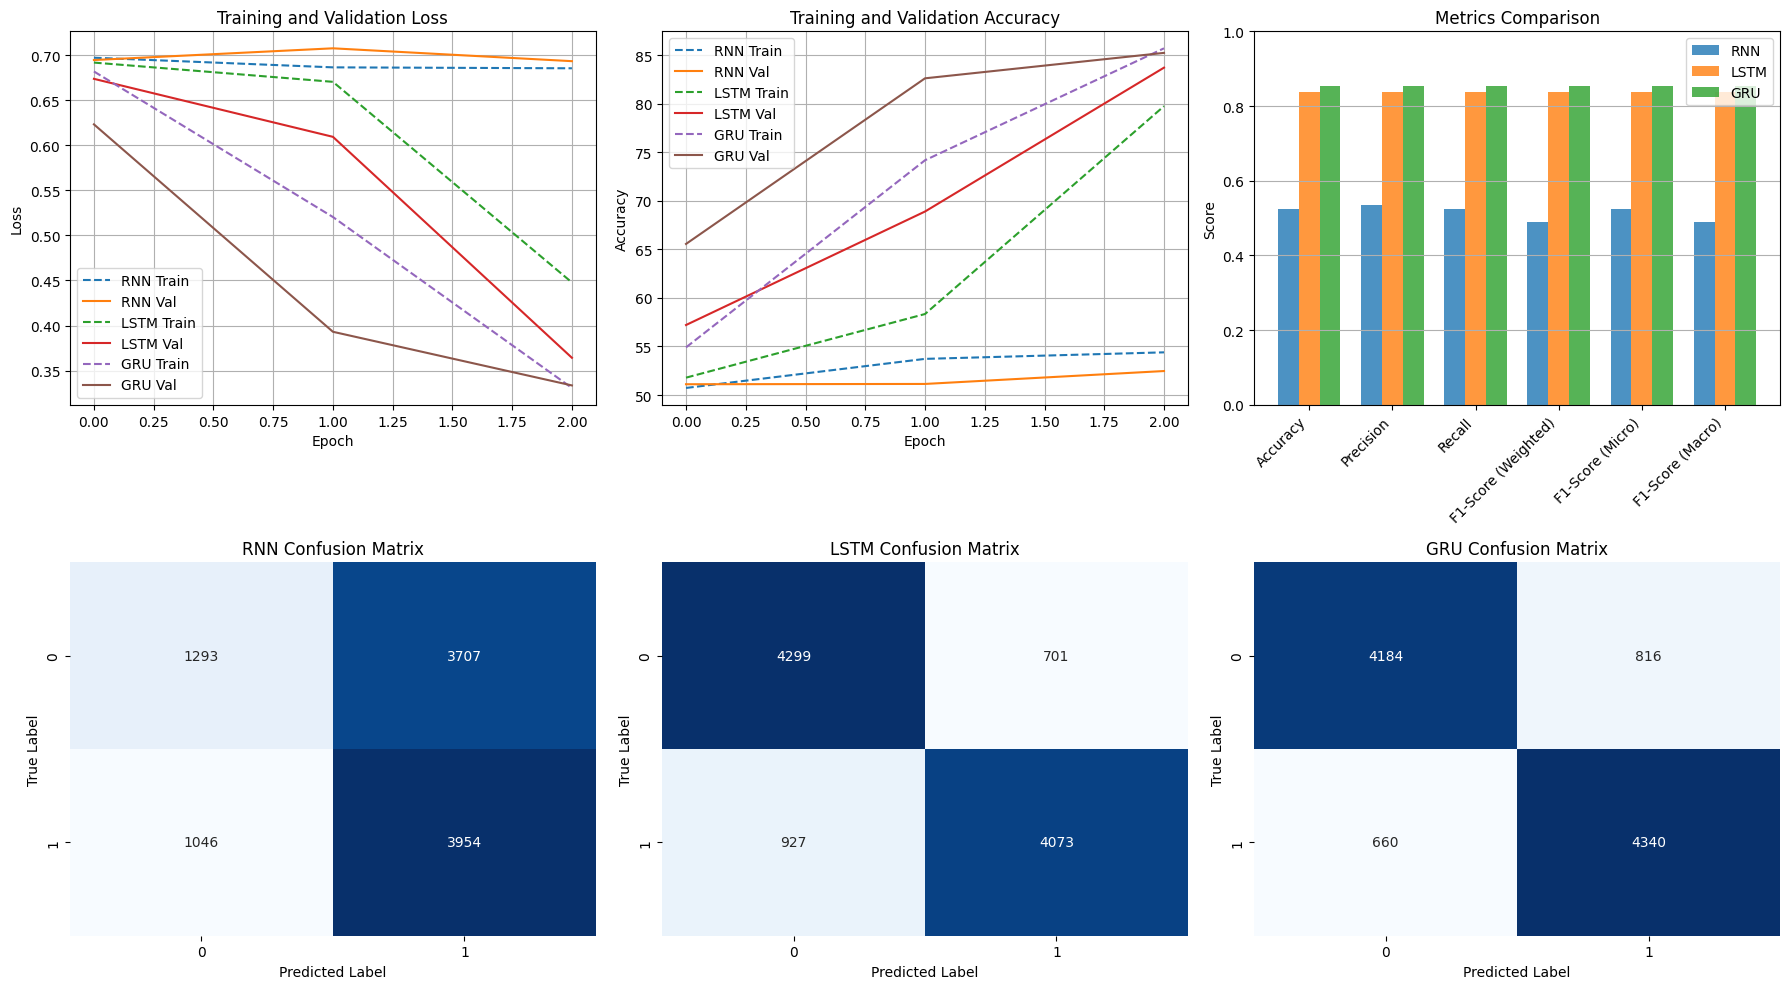

Best performing model: GRU
Highest accuracy: 0.8524


In [18]:
# Base case comparison between models

model_results = {
    'RNN': rnn_results,
    'LSTM': lstm_results,
    'GRU': gru_results
}

model_histories = {
    'RNN': rnn_history,
    'LSTM': lstm_history,
    'GRU': gru_history
}

hyperparams = {
    'Embedding dimension': 128,
    'Hidden size': 64,
    'Dropout': 0.0,
    'Learning rate': 0.001,
    'Epochs': 3,
    'Batch size': 64
}

comparison_df = plot_model_comparison(
    model_results=model_results,
    model_histories=model_histories,
    hyperparams=hyperparams,
    experiment_name="Base Case - Default Hyperparameters"
)

In [19]:
# Test Learning Rates

lr_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=[0.0001, 0.001, 0.01, 0.1],
    epochs=3,
    batch_size=64,
    experiment_name="LR_Test",
    plot_results=False
)

# plot_hyperparameter_effect(lr_experiments, 'learning_rate', metric='Accuracy', plot_type='line')
# plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='Accuracy')



RUNNING EXPERIMENT: LR_TEST_EMB128_HID64_DROP0.0_LR0.0001_EP3_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.7017, Train Acc: 50.13%
  Val Loss: 0.6971, Val Acc: 50.79%
Epoch 2/3:
  Train Loss: 0.6947, Train Acc: 51.05%
  Val Loss: 0.6957, Val Acc: 50.67%
Epoch 3/3:
  Train Loss: 0.6920, Train Acc: 51.94%
  Val Loss: 0.6948, Val Acc: 50.34%

RNN Evaluation Results:
Accuracy: 0.5034
Precision (weighted): 0.5042
Recall (weighted): 0.5034
F1-Score (weighted): 0.4782
F1-Score (micro): 0.5034
F1-Score (macro): 0.4782

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6940, Train Acc: 50.46%
  Val Loss: 0.6938, Val Acc: 50.40%
Epoch 2/3:
  Train Loss: 0.6916, Train Acc: 51.81%
  Val Loss: 0.6927, Val Acc: 51.45%
Epoch 3/3:
  Train Loss: 0.6894, Train Acc: 52.66%
  Val Loss: 0.6918, Val Acc: 51.03%

LSTM Evaluation Results:
A

In [20]:
epochs_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.001,
    epochs=[1, 3, 5, 10, 20],
    batch_size=64,
    experiment_name="Epochs_Test",
    plot_results=False
)


RUNNING EXPERIMENT: EPOCHS_TEST_EMB128_HID64_DROP0.0_LR0.001_EP1_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6980, Train Acc: 50.14%
  Val Loss: 0.6934, Val Acc: 51.12%

RNN Evaluation Results:
Accuracy: 0.5112
Precision (weighted): 0.5130
Recall (weighted): 0.5112
F1-Score (weighted): 0.4939
F1-Score (micro): 0.5112
F1-Score (macro): 0.4939

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6917, Train Acc: 51.87%
  Val Loss: 0.6784, Val Acc: 56.30%

LSTM Evaluation Results:
Accuracy: 0.5630
Precision (weighted): 0.5875
Recall (weighted): 0.5630
F1-Score (weighted): 0.5302
F1-Score (micro): 0.5630
F1-Score (macro): 0.5302

Training GRU...

Training GRU...
--------------------------------------------------
Epoch 1/1:
  Train Loss: 0.6842, Train Acc: 54.27%
  Val Loss: 0.6705, Val Acc: 63.04%

GRU Evaluation Results:

In [21]:
batch_size_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.001,
    epochs=3,
    batch_size=[16, 32, 64, 128, 256],
    experiment_name="Batch_Size_Test",
    plot_results=False
)


RUNNING EXPERIMENT: BATCH_SIZE_TEST_EMB128_HID64_DROP0.0_LR0.001_EP3_BS16_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6973, Train Acc: 51.03%
  Val Loss: 0.6917, Val Acc: 52.38%
Epoch 2/3:
  Train Loss: 0.6918, Train Acc: 52.32%
  Val Loss: 0.6911, Val Acc: 51.55%
Epoch 3/3:
  Train Loss: 0.6816, Train Acc: 54.88%
  Val Loss: 0.6862, Val Acc: 54.67%

RNN Evaluation Results:
Accuracy: 0.5467
Precision (weighted): 0.5649
Recall (weighted): 0.5467
F1-Score (weighted): 0.5125
F1-Score (micro): 0.5467
F1-Score (macro): 0.5125

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6933, Train Acc: 51.25%
  Val Loss: 0.6924, Val Acc: 51.41%
Epoch 2/3:
  Train Loss: 0.5957, Train Acc: 66.56%
  Val Loss: 0.4748, Val Acc: 78.03%
Epoch 3/3:
  Train Loss: 0.3981, Train Acc: 82.45%
  Val Loss: 0.4078, Val Acc: 81.73%

LSTM Evaluation Res

In [23]:
dropout_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=[0.0, 0.2, 0.4, 0.6],
    learning_rate=0.001,
    epochs=3,
    batch_size=64,
    experiment_name="Dropout_Test",
    plot_results=False
)


RUNNING EXPERIMENT: DROPOUT_TEST_EMB128_HID64_DROP0.0_LR0.001_EP3_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6977, Train Acc: 51.19%
  Val Loss: 0.6937, Val Acc: 50.88%
Epoch 2/3:
  Train Loss: 0.6879, Train Acc: 53.38%
  Val Loss: 0.6956, Val Acc: 51.43%
Epoch 3/3:
  Train Loss: 0.6747, Train Acc: 56.02%
  Val Loss: 0.6903, Val Acc: 55.41%

RNN Evaluation Results:
Accuracy: 0.5541
Precision (weighted): 0.5650
Recall (weighted): 0.5541
F1-Score (weighted): 0.5346
F1-Score (micro): 0.5541
F1-Score (macro): 0.5346

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6921, Train Acc: 52.02%
  Val Loss: 0.6862, Val Acc: 56.13%
Epoch 2/3:
  Train Loss: 0.6439, Train Acc: 63.23%
  Val Loss: 0.6467, Val Acc: 62.98%
Epoch 3/3:
  Train Loss: 0.4884, Train Acc: 77.25%
  Val Loss: 0.4067, Val Acc: 82.44%

LSTM Evaluation Result

In [24]:
loss_function_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.001,
    epochs=3,
    batch_size=64,
    loss_function=['CrossEntropyLoss', 'MSELoss', 'NLLLoss'],
    experiment_name="Loss_Function_Test",
    plot_results=False
)


RUNNING EXPERIMENT: LOSS_FUNCTION_TEST_EMB128_HID64_DROP0.0_LR0.001_EP3_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6964, Train Acc: 50.94%
  Val Loss: 0.6939, Val Acc: 51.11%
Epoch 2/3:
  Train Loss: 0.6869, Train Acc: 53.30%
  Val Loss: 0.6949, Val Acc: 51.09%
Epoch 3/3:
  Train Loss: 0.6783, Train Acc: 55.35%
  Val Loss: 0.7054, Val Acc: 53.25%

RNN Evaluation Results:
Accuracy: 0.5325
Precision (weighted): 0.5326
Recall (weighted): 0.5325
F1-Score (weighted): 0.5322
F1-Score (micro): 0.5325
F1-Score (macro): 0.5322

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6805, Train Acc: 55.41%
  Val Loss: 0.8837, Val Acc: 51.18%
Epoch 2/3:
  Train Loss: 0.6751, Train Acc: 56.14%
  Val Loss: 0.5618, Val Acc: 73.78%
Epoch 3/3:
  Train Loss: 0.4384, Train Acc: 80.86%
  Val Loss: 0.3834, Val Acc: 84.05%

LSTM Evaluation 

In [25]:
gradient_clipping_experiments = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.001,
    epochs=3,
    batch_size=64,
    gradient_clip=[None, 0.1, 0.5, 1.0],
    gradient_clip_type=['norm', 'value'],
    experiment_name="Gradient_Clipping_Test",
    plot_results=False
)


RUNNING EXPERIMENT: GRADIENT_CLIPPING_TEST_EMB128_HID64_DROP0.0_LR0.001_EP3_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6979, Train Acc: 50.61%
  Val Loss: 0.6950, Val Acc: 51.22%
Epoch 2/3:
  Train Loss: 0.6875, Train Acc: 53.44%
  Val Loss: 0.6897, Val Acc: 53.11%
Epoch 3/3:
  Train Loss: 0.6808, Train Acc: 55.60%
  Val Loss: 0.6993, Val Acc: 52.19%

RNN Evaluation Results:
Accuracy: 0.5219
Precision (weighted): 0.5359
Recall (weighted): 0.5219
F1-Score (weighted): 0.4703
F1-Score (micro): 0.5219
F1-Score (macro): 0.4703

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6912, Train Acc: 51.46%
  Val Loss: 0.6739, Val Acc: 56.50%
Epoch 2/3:
  Train Loss: 0.6789, Train Acc: 55.97%
  Val Loss: 0.6874, Val Acc: 54.74%
Epoch 3/3:
  Train Loss: 0.6357, Train Acc: 63.53%
  Val Loss: 0.5227, Val Acc: 76.10%

LSTM Evaluat

In [26]:
gradient_clipping_value_test = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.001,
    epochs=3,
    batch_size=64,
    gradient_clip=[None, 0.1, 0.5, 1.0],
    gradient_clip_type='value',
    experiment_name="Gradient_Clipping_Value_Test",
    plot_results=False
)


RUNNING EXPERIMENT: GRADIENT_CLIPPING_VALUE_TEST_EMB128_HID64_DROP0.0_LR0.001_EP3_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6979, Train Acc: 50.73%
  Val Loss: 0.7017, Val Acc: 50.12%
Epoch 2/3:
  Train Loss: 0.6863, Train Acc: 53.99%
  Val Loss: 0.6950, Val Acc: 50.71%
Epoch 3/3:
  Train Loss: 0.6762, Train Acc: 55.77%
  Val Loss: 0.6917, Val Acc: 53.12%

RNN Evaluation Results:
Accuracy: 0.5312
Precision (weighted): 0.5388
Recall (weighted): 0.5312
F1-Score (weighted): 0.5070
F1-Score (micro): 0.5312
F1-Score (macro): 0.5070

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6921, Train Acc: 51.86%
  Val Loss: 0.6891, Val Acc: 52.63%
Epoch 2/3:
  Train Loss: 0.6550, Train Acc: 61.69%
  Val Loss: 0.5606, Val Acc: 73.57%
Epoch 3/3:
  Train Loss: 0.4079, Train Acc: 81.57%
  Val Loss: 0.3613, Val Acc: 84.32%

LSTM E

In [27]:
gradient_clipping_norm_test = run_hyperparameter_experiment(
    embedding_dim=128,
    hidden_size=64,
    dropout=0.0,
    learning_rate=0.001,
    epochs=3,
    batch_size=64,
    gradient_clip=[None, 0.1, 0.5, 1.0],
    gradient_clip_type='norm',
    experiment_name="Gradient_Clipping_Norm_Test",
    plot_results=False
)


RUNNING EXPERIMENT: GRADIENT_CLIPPING_NORM_TEST_EMB128_HID64_DROP0.0_LR0.001_EP3_BS64_LOSSCROSSENTROPYLOSS_NOCLIP_OPTADAM

Training RNN...

Training RNN...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6985, Train Acc: 50.39%
  Val Loss: 0.6955, Val Acc: 50.41%
Epoch 2/3:
  Train Loss: 0.6884, Train Acc: 53.37%
  Val Loss: 0.6951, Val Acc: 51.89%
Epoch 3/3:
  Train Loss: 0.6827, Train Acc: 54.39%
  Val Loss: 0.6945, Val Acc: 50.78%

RNN Evaluation Results:
Accuracy: 0.5078
Precision (weighted): 0.5162
Recall (weighted): 0.5078
F1-Score (weighted): 0.4345
F1-Score (micro): 0.5078
F1-Score (macro): 0.4345

Training LSTM...

Training LSTM...
--------------------------------------------------
Epoch 1/3:
  Train Loss: 0.6908, Train Acc: 52.12%
  Val Loss: 0.6845, Val Acc: 53.63%
Epoch 2/3:
  Train Loss: 0.6625, Train Acc: 59.98%
  Val Loss: 0.6316, Val Acc: 64.72%
Epoch 3/3:
  Train Loss: 0.5792, Train Acc: 70.47%
  Val Loss: 0.5261, Val Acc: 75.66%

LSTM Ev

### Plots by hyperparameter (Accuracy + F1)

<Figure size 1200x600 with 0 Axes>

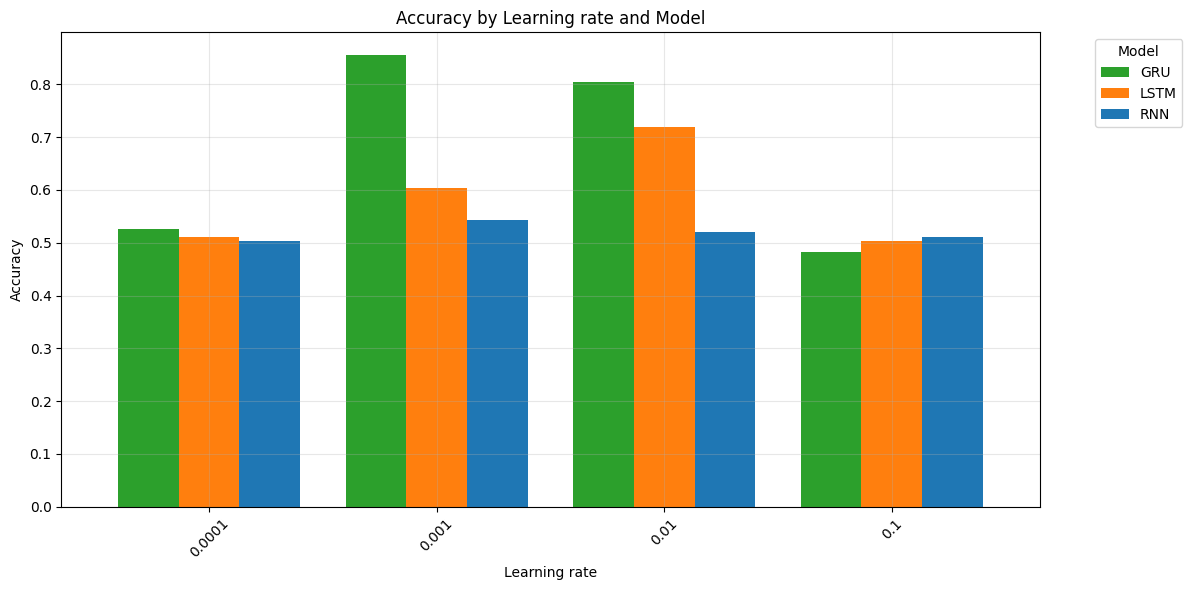


Detailed Accuracy Comparison by Learning rate:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0001          0.5253  0.5103  0.5034
0.0010          0.8559  0.6040  0.5423
0.0100          0.8043  0.7189  0.5204
0.1000          0.4819  0.5031  0.5117


<Figure size 1200x600 with 0 Axes>

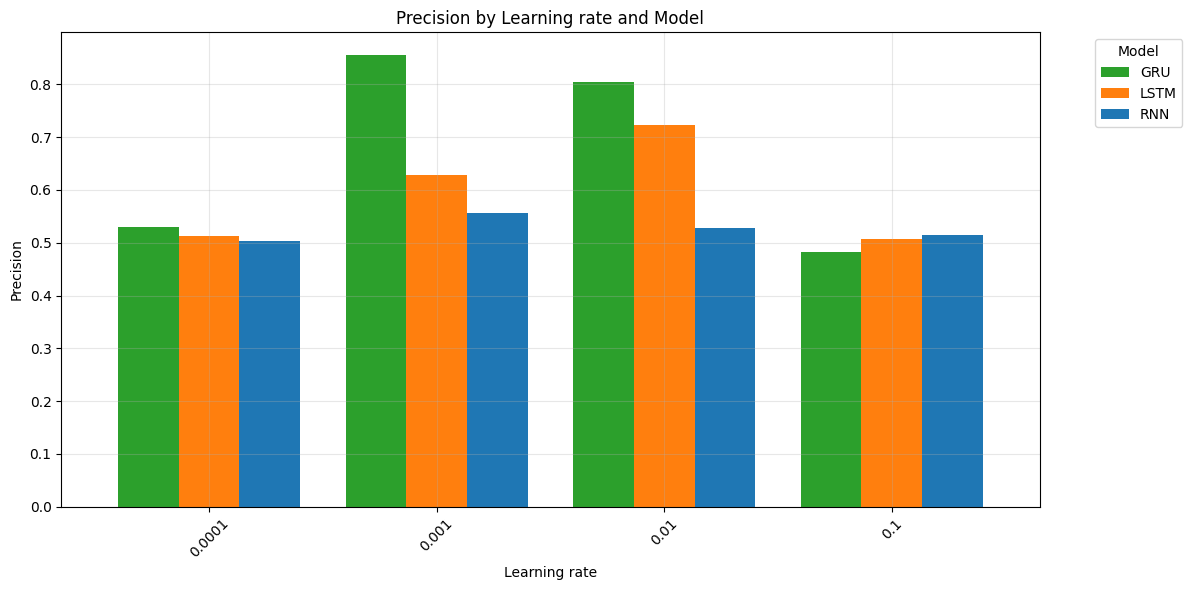


Detailed Precision Comparison by Learning rate:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0001          0.5308  0.5127  0.5042
0.0010          0.8559  0.6289  0.5559
0.0100          0.8053  0.7233  0.5288
0.1000          0.4819  0.5063  0.5151


<Figure size 1200x600 with 0 Axes>

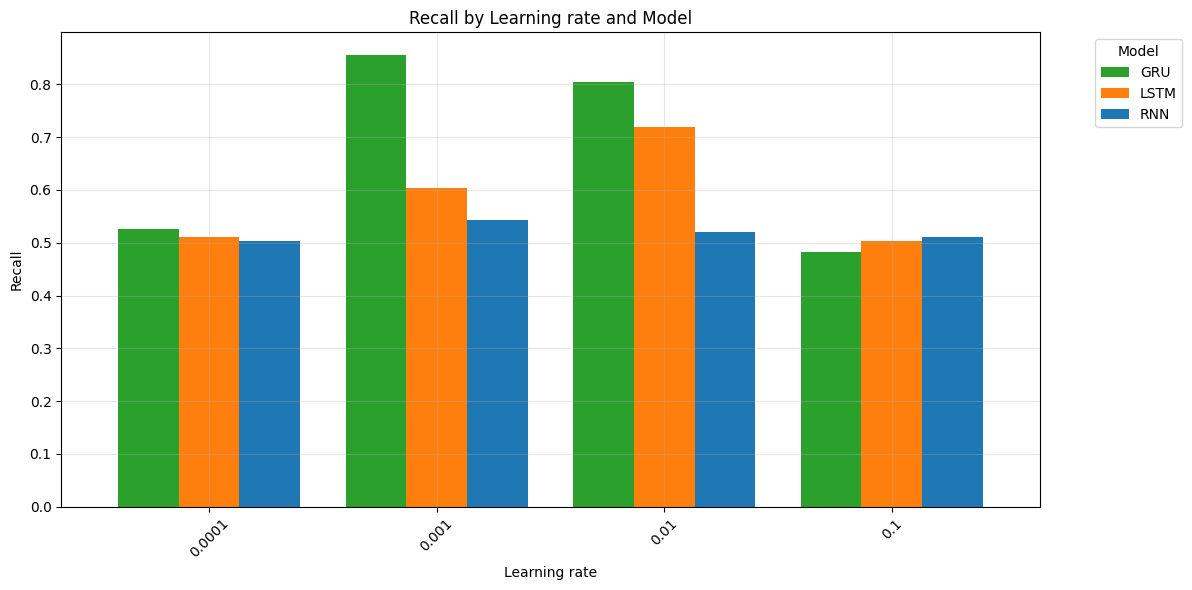


Detailed Recall Comparison by Learning rate:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0001          0.5253  0.5103  0.5034
0.0010          0.8559  0.6040  0.5423
0.0100          0.8043  0.7189  0.5204
0.1000          0.4819  0.5031  0.5117


<Figure size 1200x600 with 0 Axes>

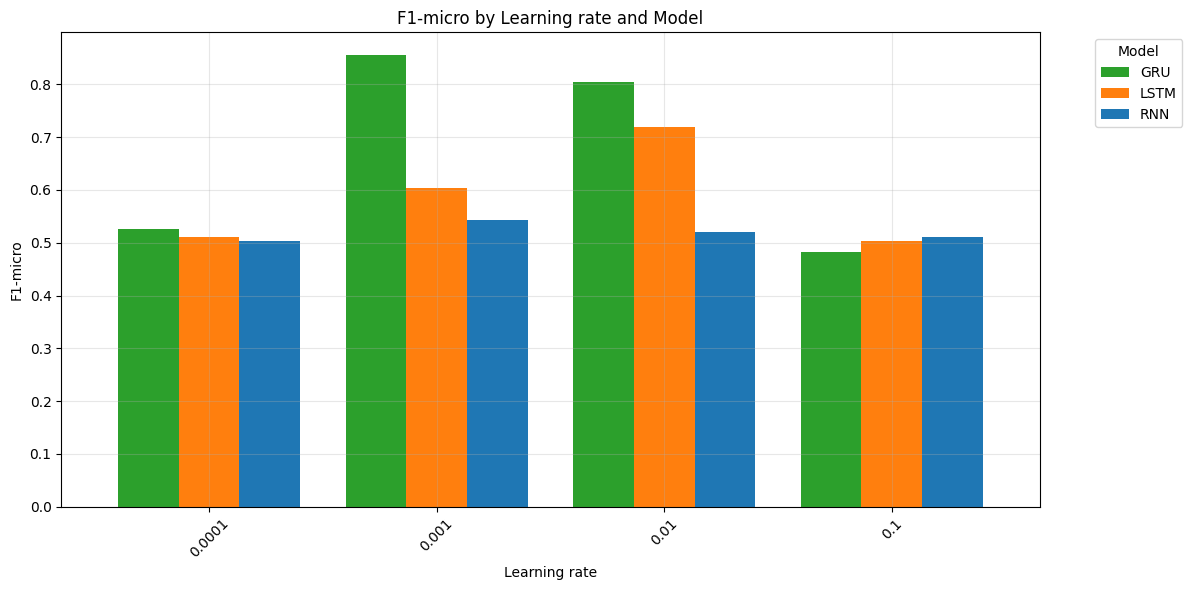


Detailed F1-micro Comparison by Learning rate:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0001          0.5253  0.5103  0.5034
0.0010          0.8559  0.6040  0.5423
0.0100          0.8043  0.7189  0.5204
0.1000          0.4819  0.5031  0.5117


<Figure size 1200x600 with 0 Axes>

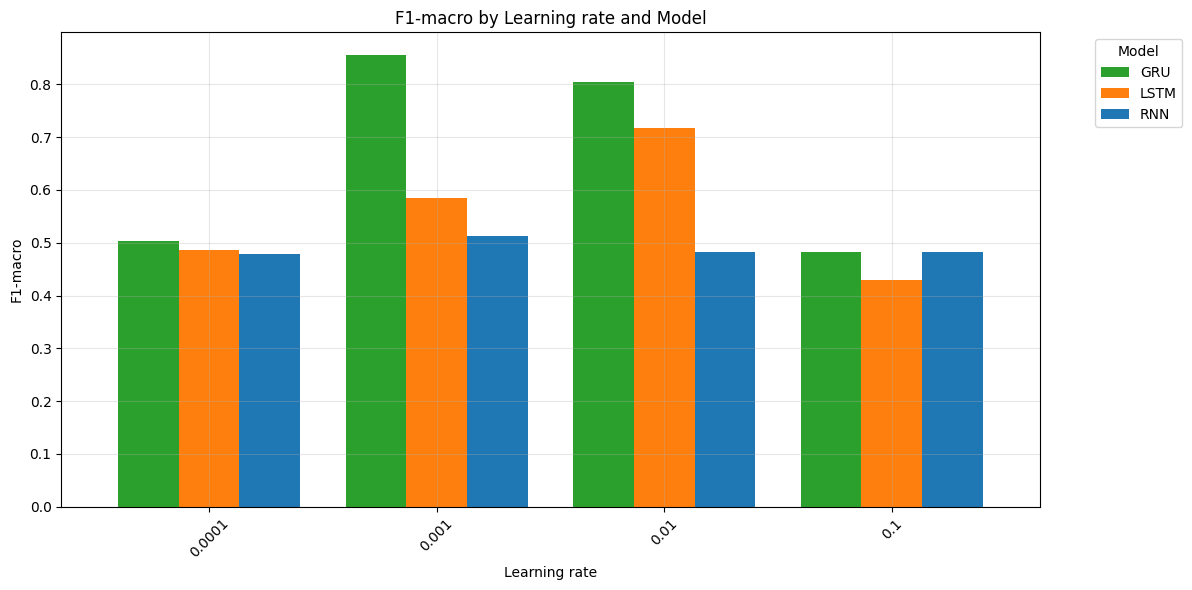


Detailed F1-macro Comparison by Learning rate:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0001          0.5030  0.4860  0.4782
0.0010          0.8559  0.5839  0.5126
0.0100          0.8041  0.7175  0.4827
0.1000          0.4819  0.4304  0.4826


<Figure size 1200x600 with 0 Axes>

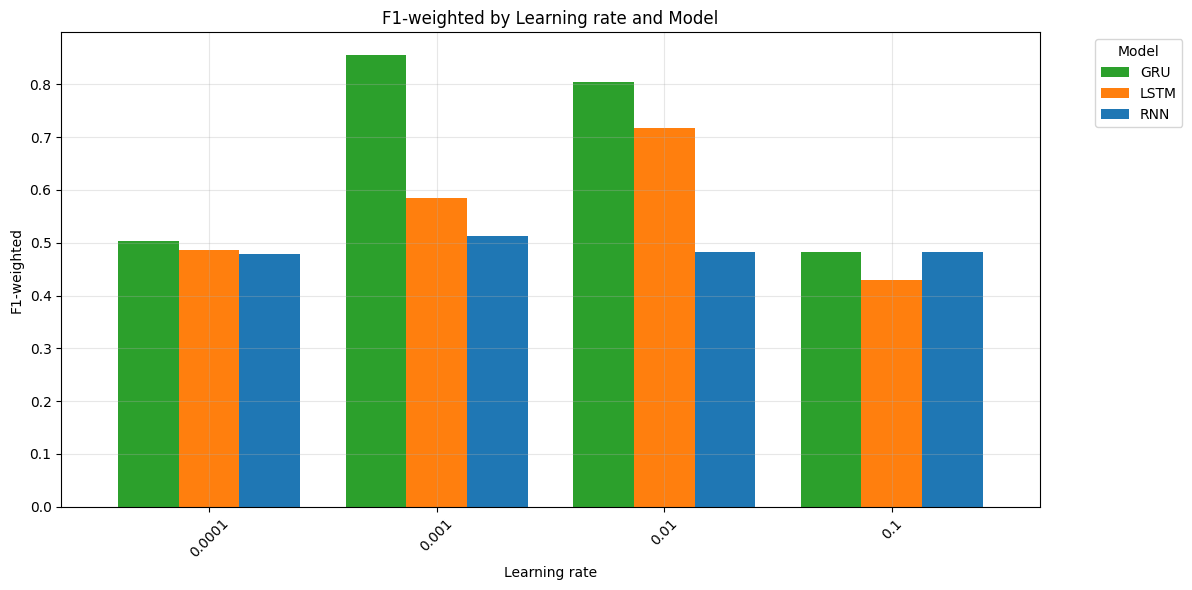


Detailed F1-weighted Comparison by Learning rate:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0001          0.5030  0.4860  0.4782
0.0010          0.8559  0.5839  0.5126
0.0100          0.8041  0.7175  0.4827
0.1000          0.4819  0.4304  0.4826


,Model,Hyperparameter,Metric
0,RNN,0.0001,0.478238
1,LSTM,0.0001,0.485984
2,GRU,0.0001,0.503027
3,RNN,0.0010,0.512588
4,LSTM,0.0010,0.583936
5,GRU,0.0010,0.855899
6,RNN,0.0100,0.482748
7,LSTM,0.0100,0.717504
8,GRU,0.0100,0.804143
9,RNN,0.1000,0.482614


In [30]:
plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='Accuracy')
plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='Precision')
plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='Recall')
plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='F1-micro')
plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='F1-macro')
plot_model_comparison_by_hp(lr_experiments, 'learning_rate', metric='F1-weighted')

<Figure size 1200x600 with 0 Axes>

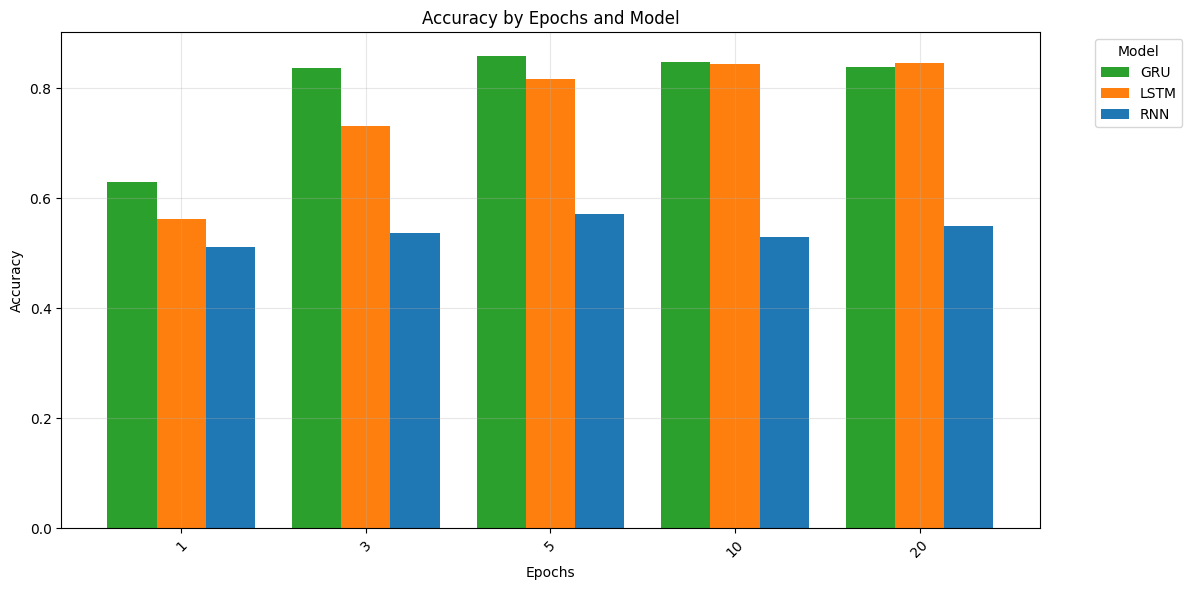


Detailed Accuracy Comparison by Epochs:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
1               0.6304  0.5630  0.5112
3               0.8371  0.7310  0.5366
5               0.8590  0.8171  0.5715
10              0.8476  0.8445  0.5305
20              0.8389  0.8456  0.5506


<Figure size 1200x600 with 0 Axes>

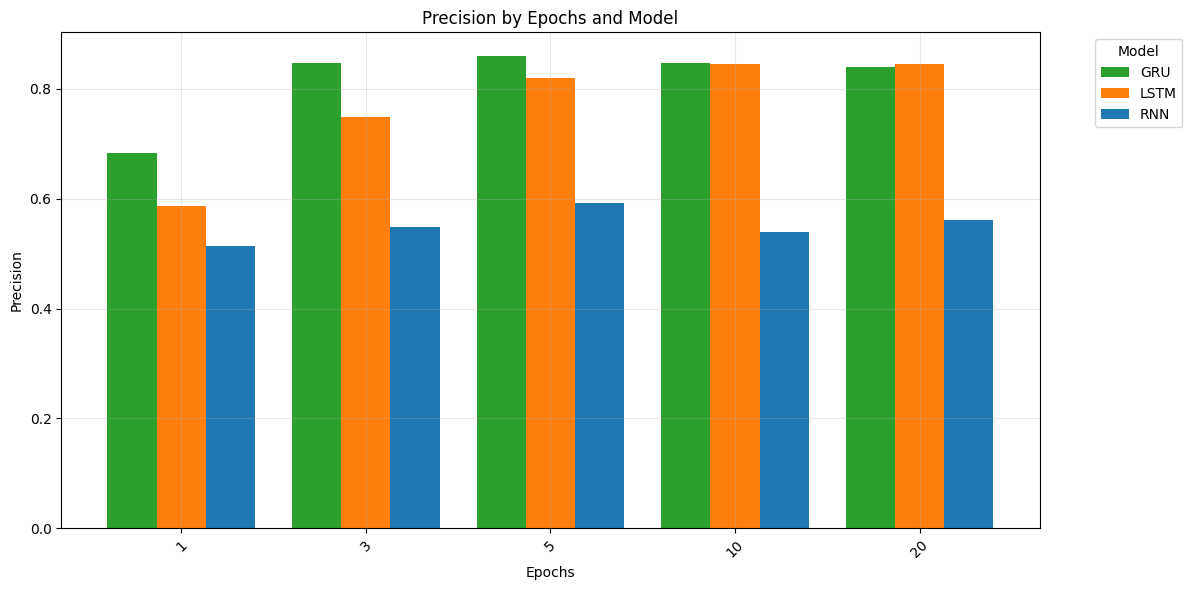


Detailed Precision Comparison by Epochs:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
1               0.6839  0.5875  0.5130
3               0.8474  0.7480  0.5491
5               0.8596  0.8192  0.5912
10              0.8477  0.8445  0.5398
20              0.8391  0.8456  0.5606


<Figure size 1200x600 with 0 Axes>

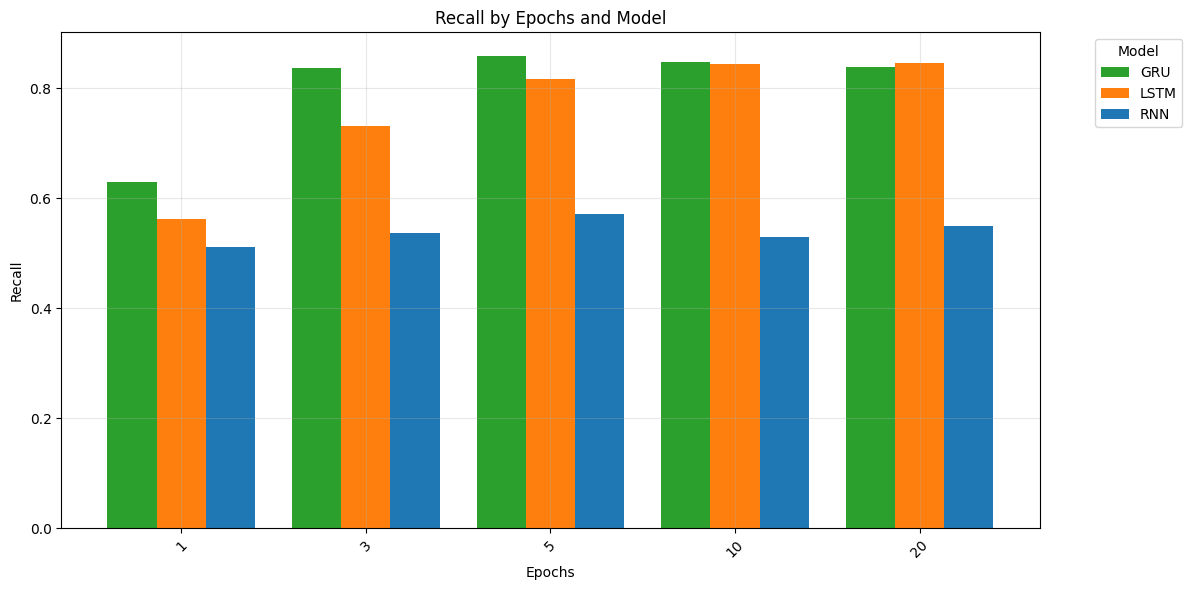


Detailed Recall Comparison by Epochs:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
1               0.6304  0.5630  0.5112
3               0.8371  0.7310  0.5366
5               0.8590  0.8171  0.5715
10              0.8476  0.8445  0.5305
20              0.8389  0.8456  0.5506


<Figure size 1200x600 with 0 Axes>

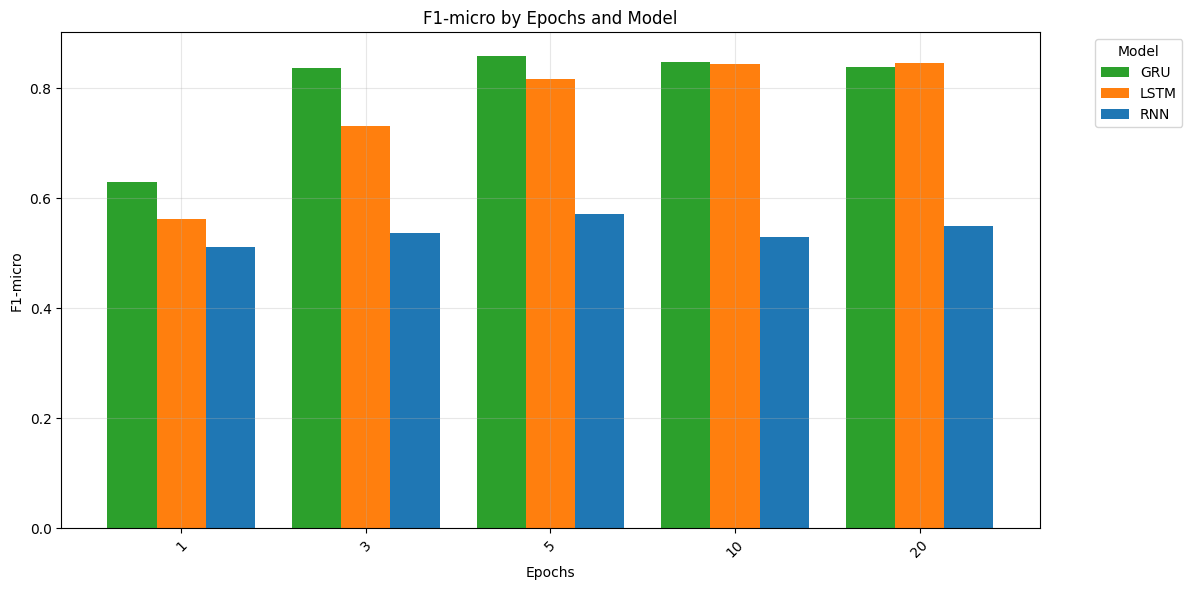


Detailed F1-micro Comparison by Epochs:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
1               0.6304  0.5630  0.5112
3               0.8371  0.7310  0.5366
5               0.8590  0.8171  0.5715
10              0.8476  0.8445  0.5305
20              0.8389  0.8456  0.5506


<Figure size 1200x600 with 0 Axes>

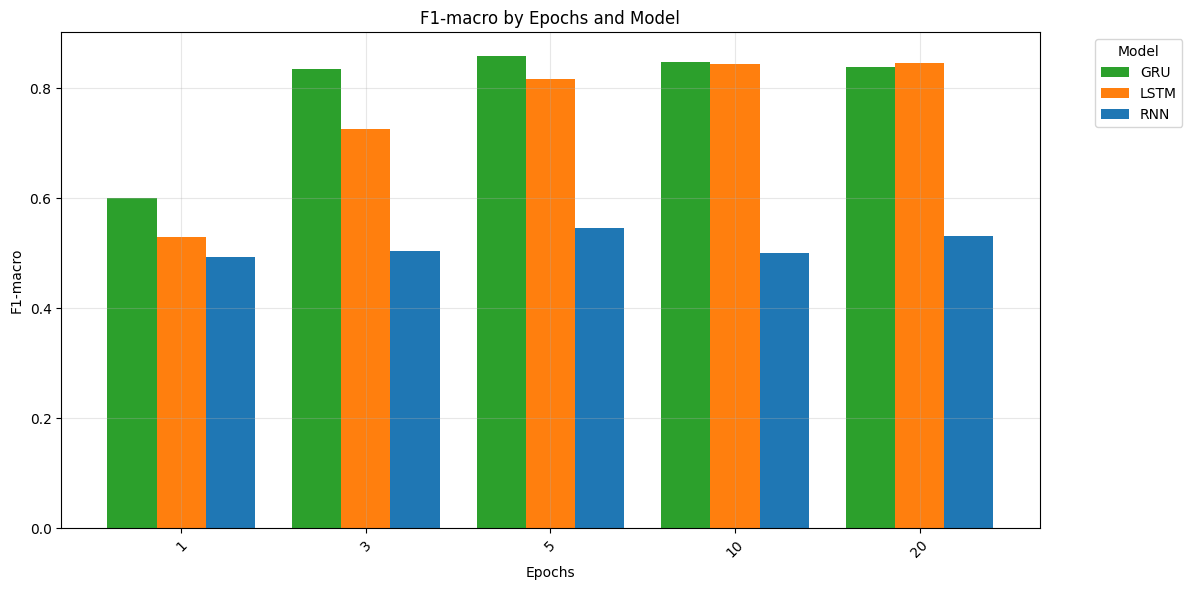


Detailed F1-macro Comparison by Epochs:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
1               0.6014  0.5302  0.4939
3               0.8359  0.7263  0.5051
5               0.8589  0.8168  0.5470
10              0.8476  0.8445  0.5013
20              0.8389  0.8456  0.5313


<Figure size 1200x600 with 0 Axes>

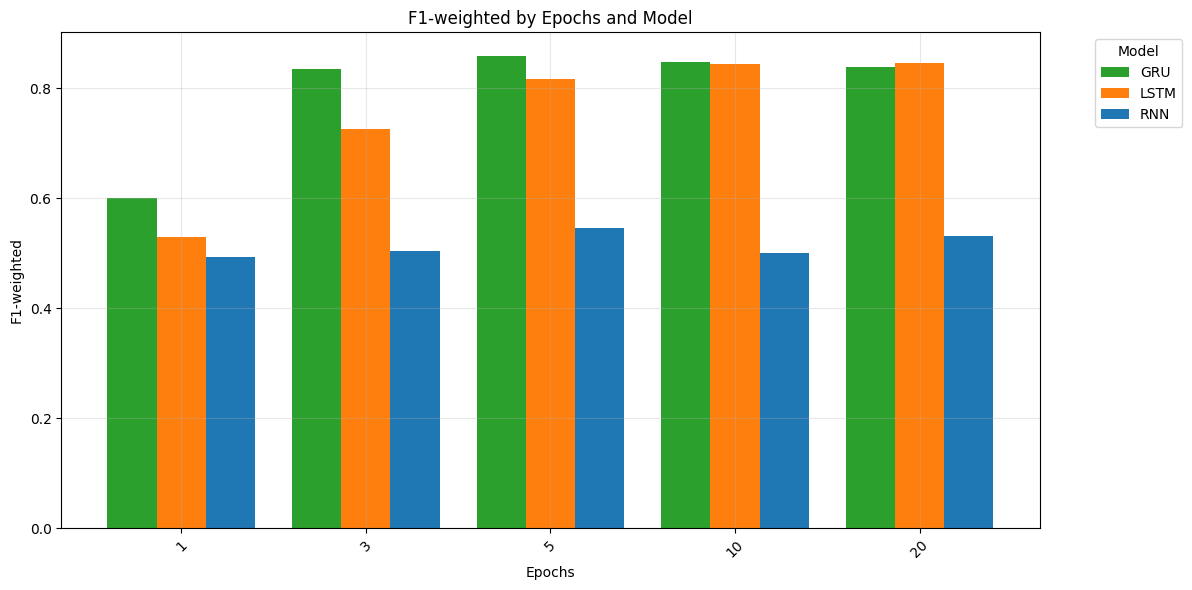


Detailed F1-weighted Comparison by Epochs:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
1               0.6014  0.5302  0.4939
3               0.8359  0.7263  0.5051
5               0.8589  0.8168  0.5470
10              0.8476  0.8445  0.5013
20              0.8389  0.8456  0.5313


,Model,Hyperparameter,Metric
0,RNN,1,0.493917
1,LSTM,1,0.530154
2,GRU,1,0.601430
3,RNN,3,0.505070
4,LSTM,3,0.726303
5,GRU,3,0.835883
6,RNN,5,0.547013
7,LSTM,5,0.816800
8,GRU,5,0.858938
9,RNN,10,0.501268


In [31]:
plot_model_comparison_by_hp(epochs_experiments, 'epochs', metric='Accuracy')
plot_model_comparison_by_hp(epochs_experiments, 'epochs', metric='Precision')
plot_model_comparison_by_hp(epochs_experiments, 'epochs', metric='Recall')
plot_model_comparison_by_hp(epochs_experiments, 'epochs', metric='F1-micro')
plot_model_comparison_by_hp(epochs_experiments, 'epochs', metric='F1-macro')
plot_model_comparison_by_hp(epochs_experiments, 'epochs', metric='F1-weighted')


<Figure size 1200x600 with 0 Axes>

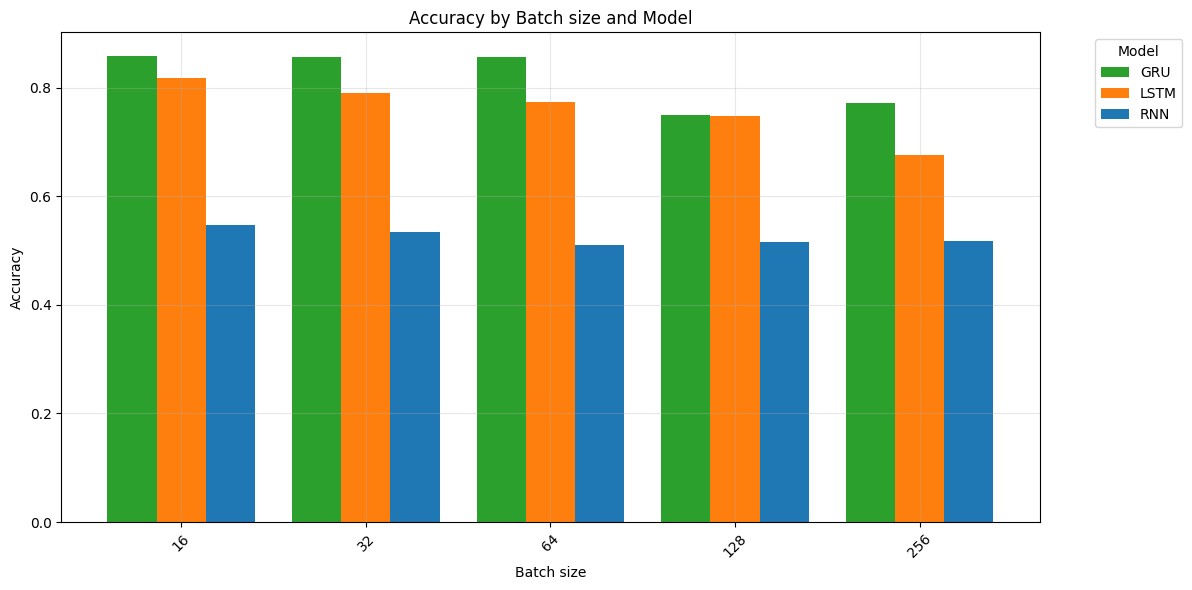


Detailed Accuracy Comparison by Batch size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8591  0.8173  0.5467
32              0.8571  0.7912  0.5351
64              0.8566  0.7742  0.5111
128             0.7502  0.7472  0.5167
256             0.7720  0.6761  0.5185


<Figure size 1200x600 with 0 Axes>

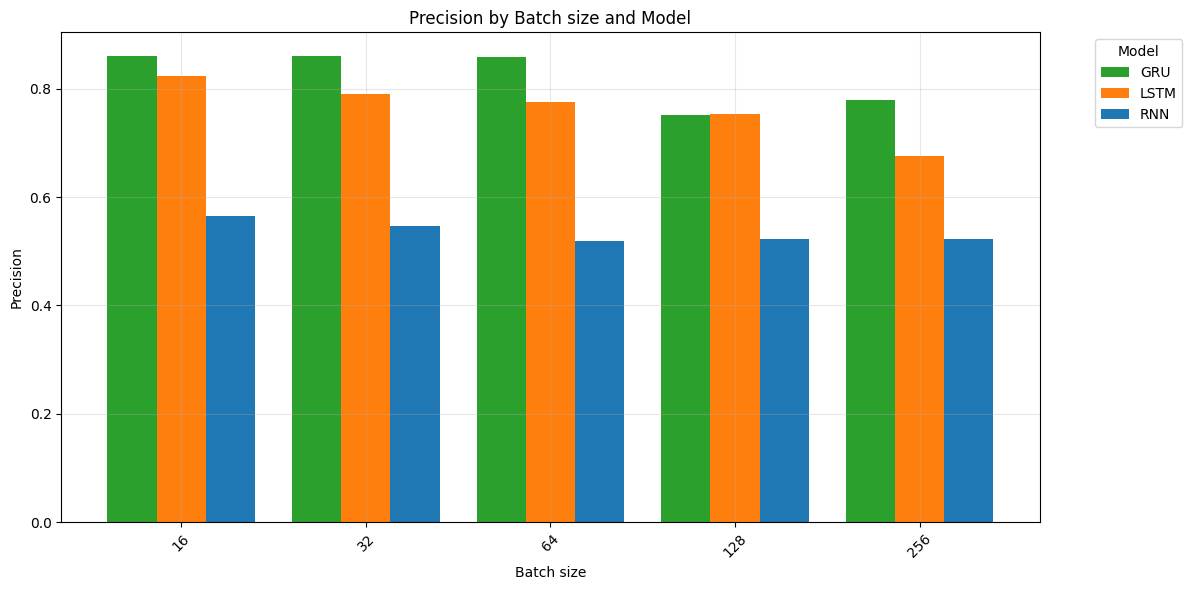


Detailed Precision Comparison by Batch size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8606  0.8242  0.5649
32              0.8611  0.7912  0.5472
64              0.8586  0.7759  0.5183
128             0.7507  0.7540  0.5220
256             0.7785  0.6763  0.5233


<Figure size 1200x600 with 0 Axes>

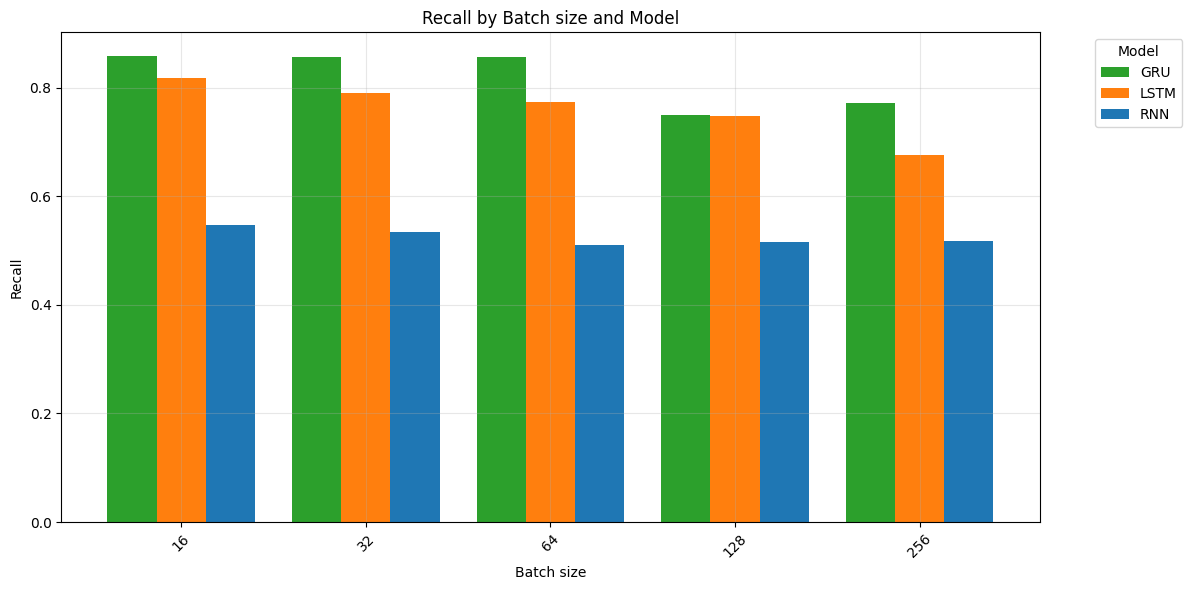


Detailed Recall Comparison by Batch size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8591  0.8173  0.5467
32              0.8571  0.7912  0.5351
64              0.8566  0.7742  0.5111
128             0.7502  0.7472  0.5167
256             0.7720  0.6761  0.5185


<Figure size 1200x600 with 0 Axes>

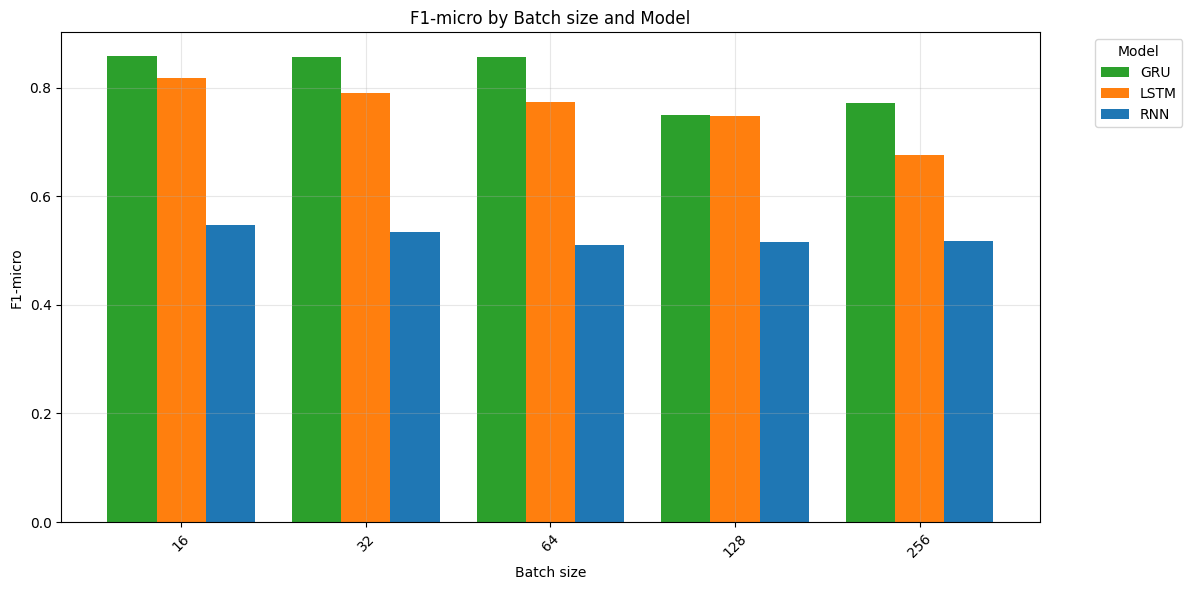


Detailed F1-micro Comparison by Batch size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8591  0.8173  0.5467
32              0.8571  0.7912  0.5351
64              0.8566  0.7742  0.5111
128             0.7502  0.7472  0.5167
256             0.7720  0.6761  0.5185


<Figure size 1200x600 with 0 Axes>

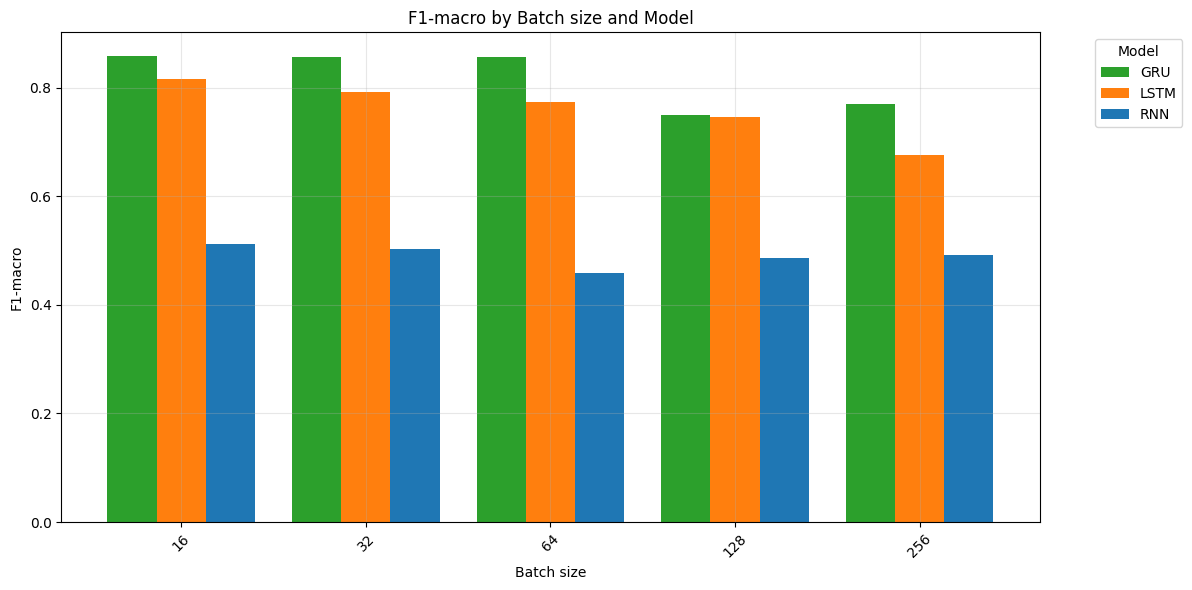


Detailed F1-macro Comparison by Batch size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8590  0.8163  0.5125
32              0.8567  0.7912  0.5033
64              0.8564  0.7739  0.4578
128             0.7501  0.7455  0.4859
256             0.7707  0.6760  0.4923


<Figure size 1200x600 with 0 Axes>

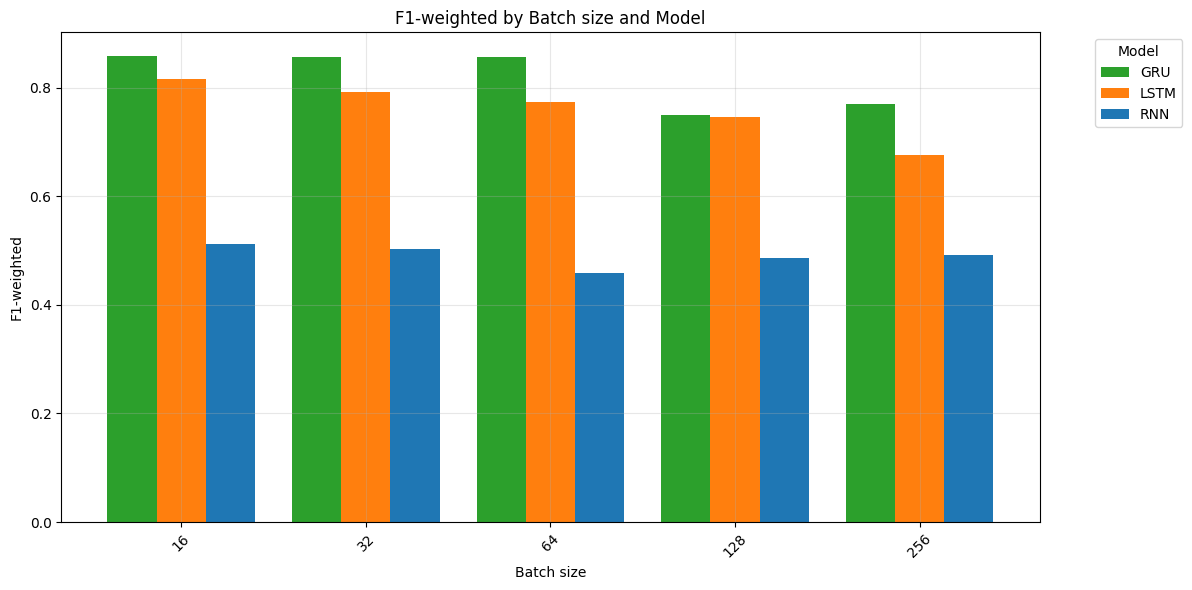


Detailed F1-weighted Comparison by Batch size:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
16              0.8590  0.8163  0.5125
32              0.8567  0.7912  0.5033
64              0.8564  0.7739  0.4578
128             0.7501  0.7455  0.4859
256             0.7707  0.6760  0.4923


,Model,Hyperparameter,Metric
0,RNN,16,0.512490
1,LSTM,16,0.816324
2,GRU,16,0.858951
3,RNN,32,0.503334
4,LSTM,32,0.791200
5,GRU,32,0.856702
6,RNN,64,0.457813
7,LSTM,64,0.773860
8,GRU,64,0.856399
9,RNN,128,0.485864


In [32]:
plot_model_comparison_by_hp(batch_size_experiments, 'batch_size', metric='Accuracy')
plot_model_comparison_by_hp(batch_size_experiments, 'batch_size', metric='Precision')
plot_model_comparison_by_hp(batch_size_experiments, 'batch_size', metric='Recall')
plot_model_comparison_by_hp(batch_size_experiments, 'batch_size', metric='F1-micro')
plot_model_comparison_by_hp(batch_size_experiments, 'batch_size', metric='F1-macro')
plot_model_comparison_by_hp(batch_size_experiments, 'batch_size', metric='F1-weighted')


(Hidden layers number not so important)

<Figure size 1200x600 with 0 Axes>

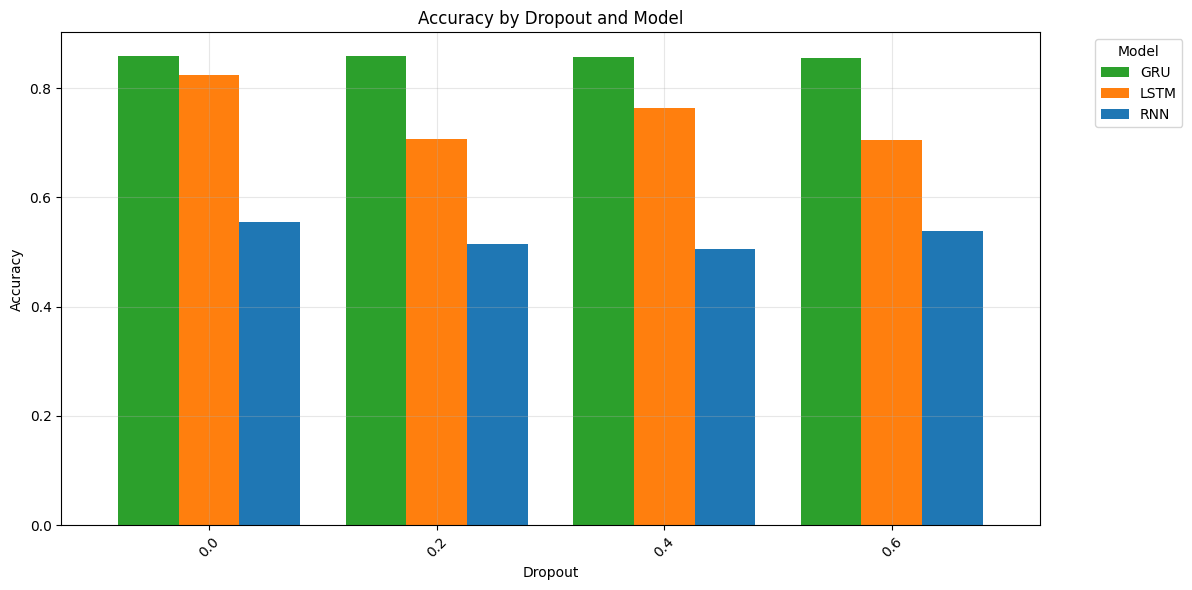


Detailed Accuracy Comparison by Dropout:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0             0.8584  0.8244  0.5541
0.2             0.8591  0.7069  0.5147
0.4             0.8577  0.7642  0.5064
0.6             0.8552  0.7048  0.5378


<Figure size 1200x600 with 0 Axes>

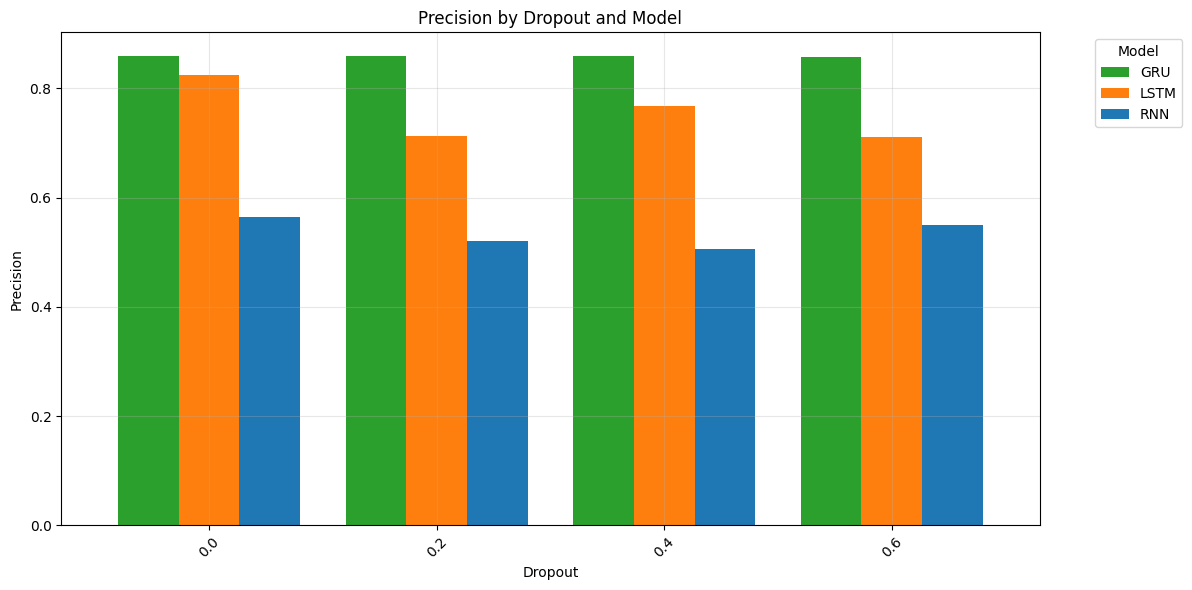


Detailed Precision Comparison by Dropout:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0             0.8585  0.8244  0.5650
0.2             0.8591  0.7128  0.5201
0.4             0.8596  0.7671  0.5064
0.6             0.8566  0.7118  0.5504


<Figure size 1200x600 with 0 Axes>

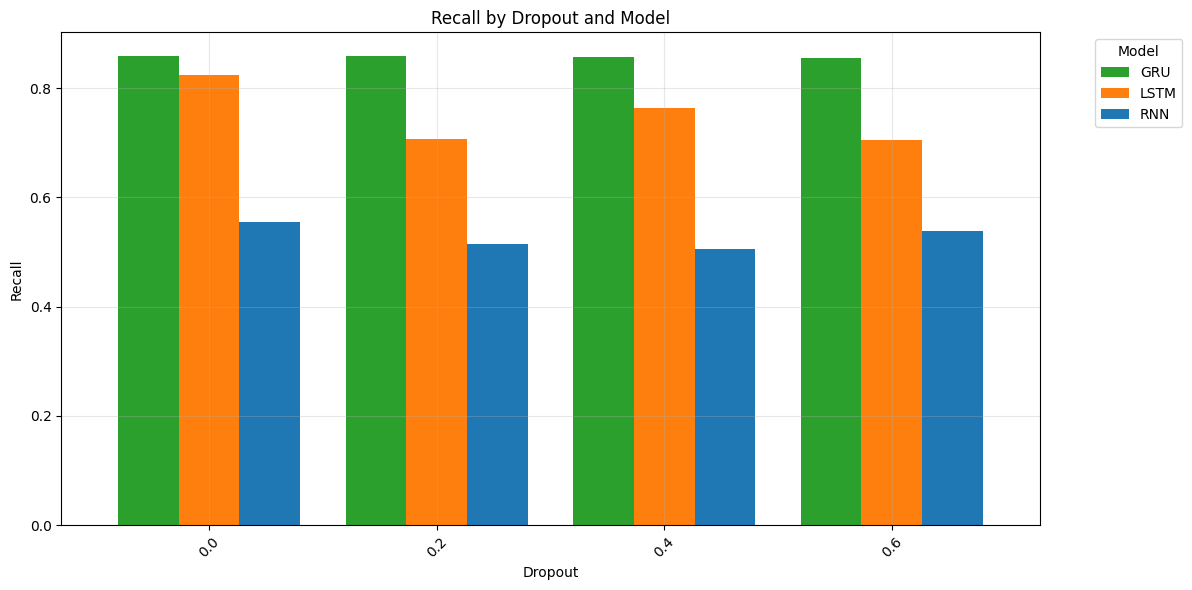


Detailed Recall Comparison by Dropout:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0             0.8584  0.8244  0.5541
0.2             0.8591  0.7069  0.5147
0.4             0.8577  0.7642  0.5064
0.6             0.8552  0.7048  0.5378


<Figure size 1200x600 with 0 Axes>

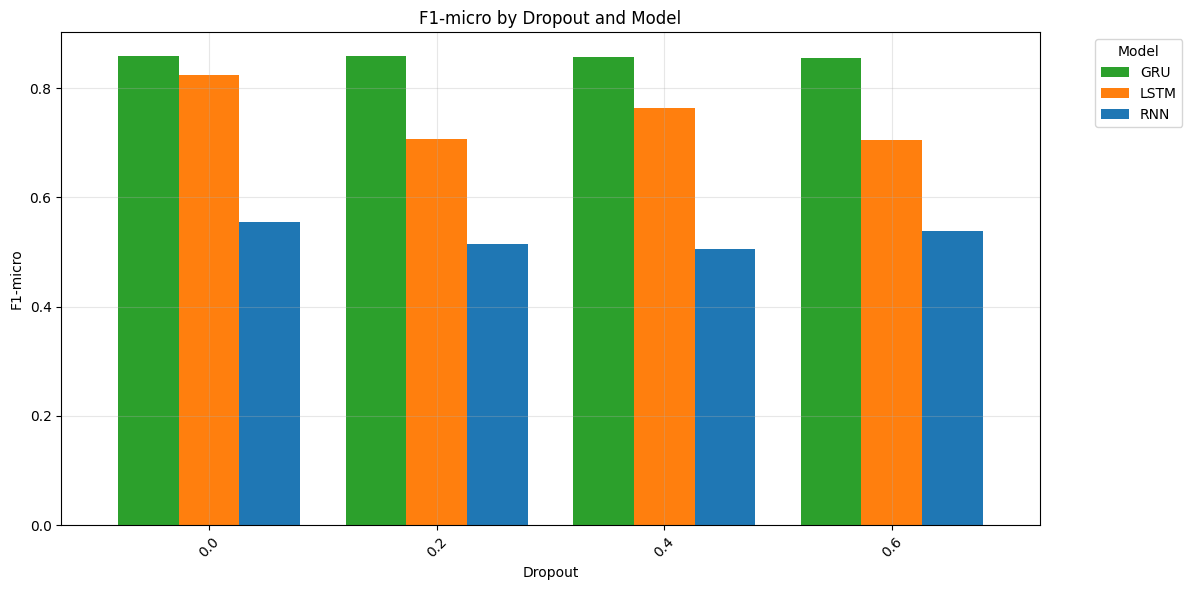


Detailed F1-micro Comparison by Dropout:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0             0.8584  0.8244  0.5541
0.2             0.8591  0.7069  0.5147
0.4             0.8577  0.7642  0.5064
0.6             0.8552  0.7048  0.5378


<Figure size 1200x600 with 0 Axes>

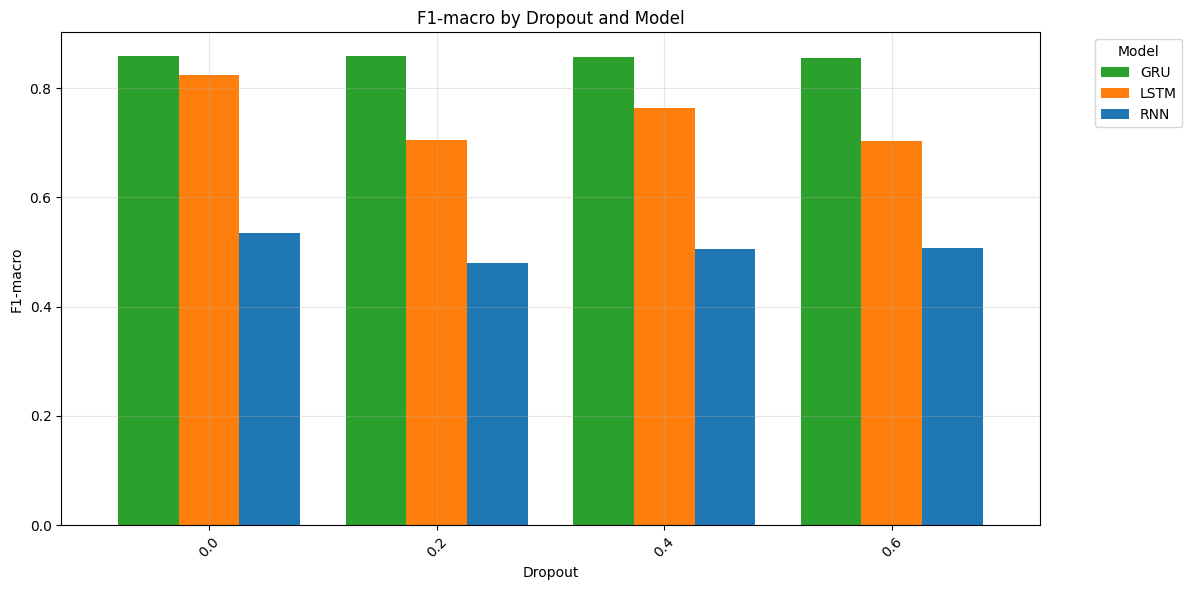


Detailed F1-macro Comparison by Dropout:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0             0.8584  0.8244  0.5346
0.2             0.8591  0.7049  0.4799
0.4             0.8575  0.7636  0.5056
0.6             0.8551  0.7023  0.5069


<Figure size 1200x600 with 0 Axes>

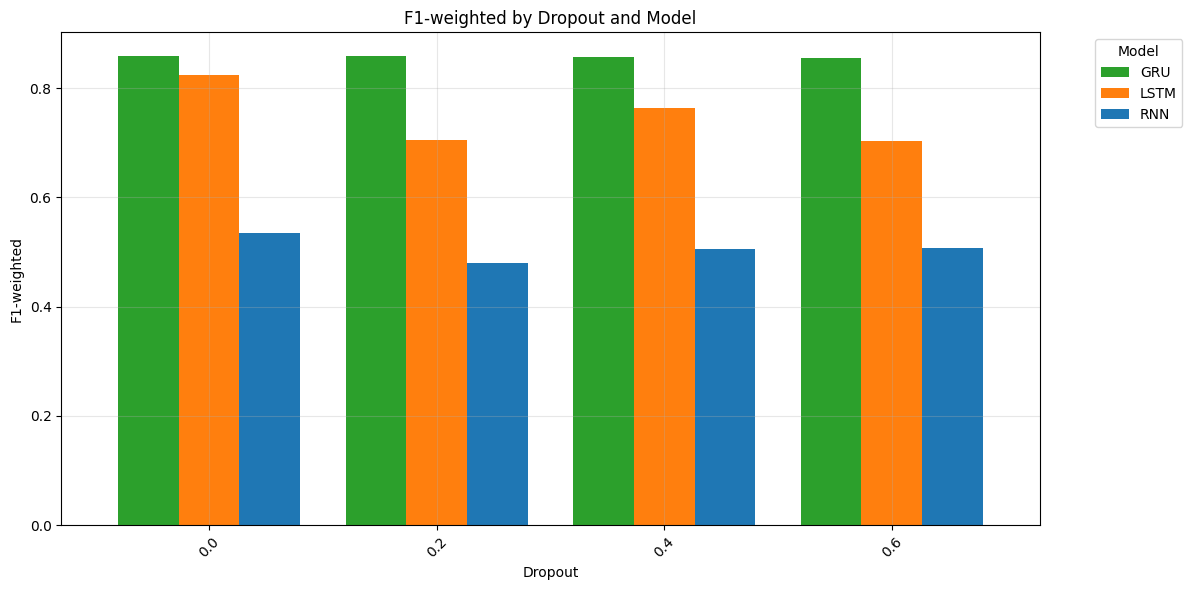


Detailed F1-weighted Comparison by Dropout:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
0.0             0.8584  0.8244  0.5346
0.2             0.8591  0.7049  0.4799
0.4             0.8575  0.7636  0.5056
0.6             0.8551  0.7023  0.5069


,Model,Hyperparameter,Metric
0,RNN,0.0,0.534599
1,LSTM,0.0,0.824396
2,GRU,0.0,0.858392
3,RNN,0.2,0.479949
4,LSTM,0.2,0.704862
5,GRU,0.2,0.859099
6,RNN,0.4,0.505625
7,LSTM,0.4,0.763566
8,GRU,0.4,0.857512
9,RNN,0.6,0.506934


In [34]:
plot_model_comparison_by_hp(dropout_experiments, 'dropout', metric='Accuracy')
plot_model_comparison_by_hp(dropout_experiments, 'dropout', metric='Precision')
plot_model_comparison_by_hp(dropout_experiments, 'dropout', metric='Recall')
plot_model_comparison_by_hp(dropout_experiments, 'dropout', metric='F1-micro')
plot_model_comparison_by_hp(dropout_experiments, 'dropout', metric='F1-macro')
plot_model_comparison_by_hp(dropout_experiments, 'dropout', metric='F1-weighted')


<Figure size 1200x600 with 0 Axes>

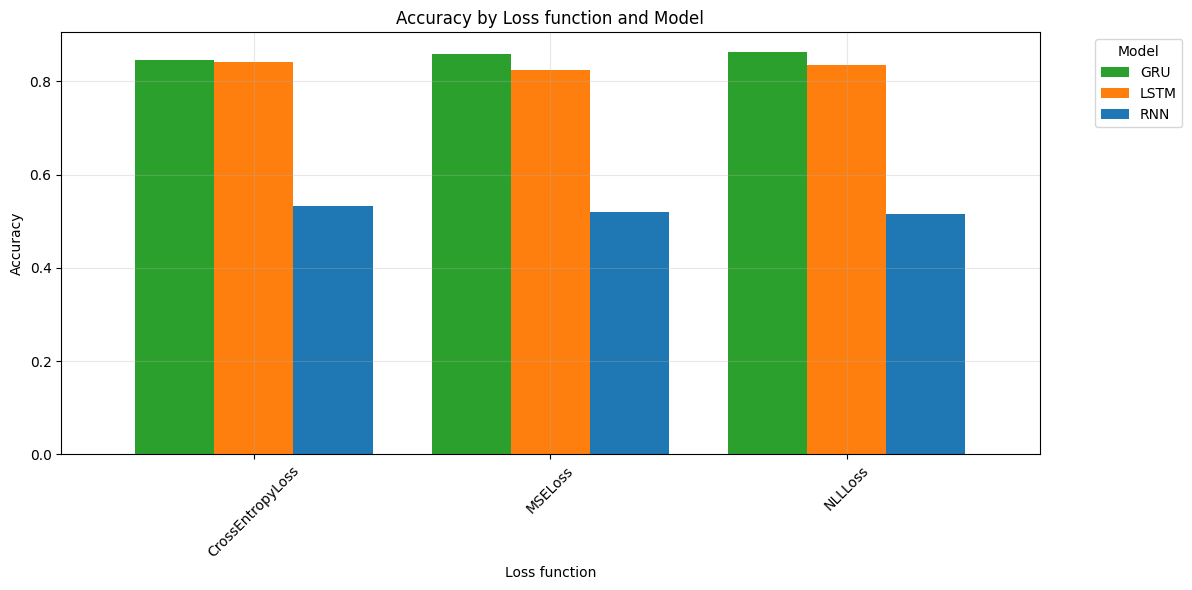


Detailed Accuracy Comparison by Loss function:
------------------------------------------------------------
Model                GRU    LSTM     RNN
Hyperparameter                          
CrossEntropyLoss  0.8457  0.8405  0.5325
MSELoss           0.8582  0.8253  0.5203
NLLLoss           0.8620  0.8347  0.5155


<Figure size 1200x600 with 0 Axes>

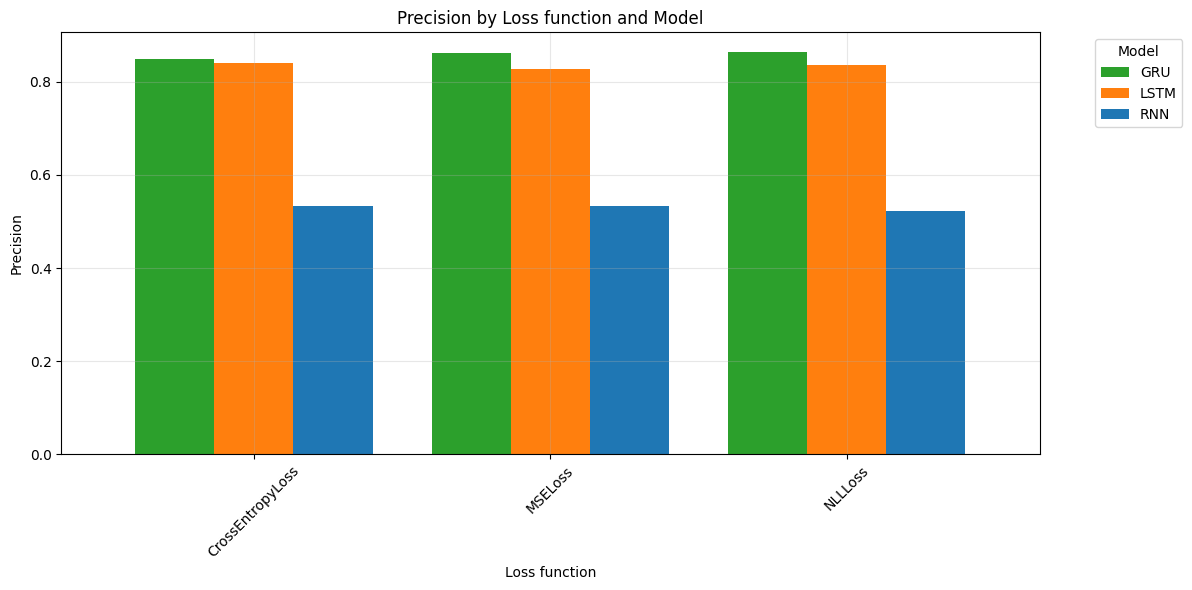


Detailed Precision Comparison by Loss function:
------------------------------------------------------------
Model                GRU    LSTM     RNN
Hyperparameter                          
CrossEntropyLoss  0.8495  0.8413  0.5326
MSELoss           0.8624  0.8283  0.5326
NLLLoss           0.8630  0.8363  0.5230


<Figure size 1200x600 with 0 Axes>

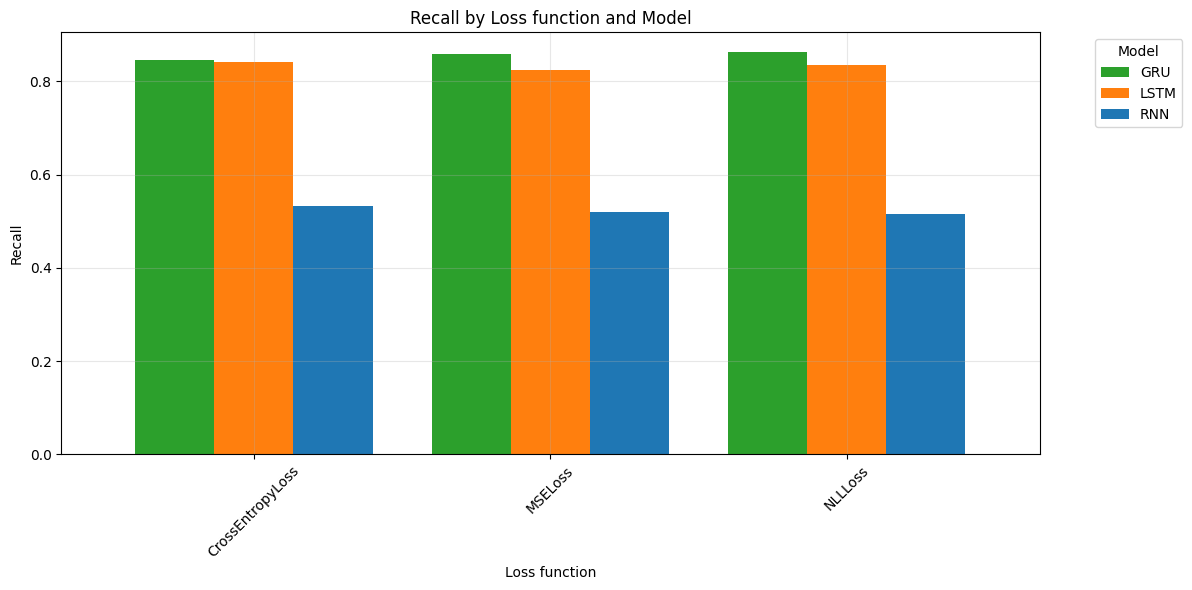


Detailed Recall Comparison by Loss function:
------------------------------------------------------------
Model                GRU    LSTM     RNN
Hyperparameter                          
CrossEntropyLoss  0.8457  0.8405  0.5325
MSELoss           0.8582  0.8253  0.5203
NLLLoss           0.8620  0.8347  0.5155


<Figure size 1200x600 with 0 Axes>

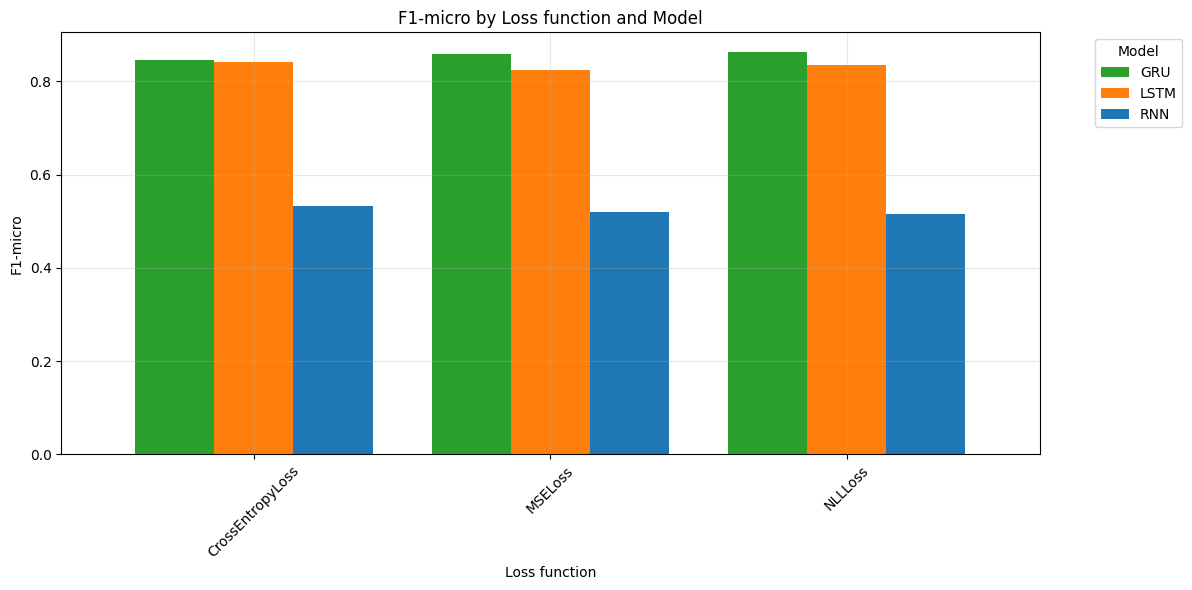


Detailed F1-micro Comparison by Loss function:
------------------------------------------------------------
Model                GRU    LSTM     RNN
Hyperparameter                          
CrossEntropyLoss  0.8457  0.8405  0.5325
MSELoss           0.8582  0.8253  0.5203
NLLLoss           0.8620  0.8347  0.5155


<Figure size 1200x600 with 0 Axes>

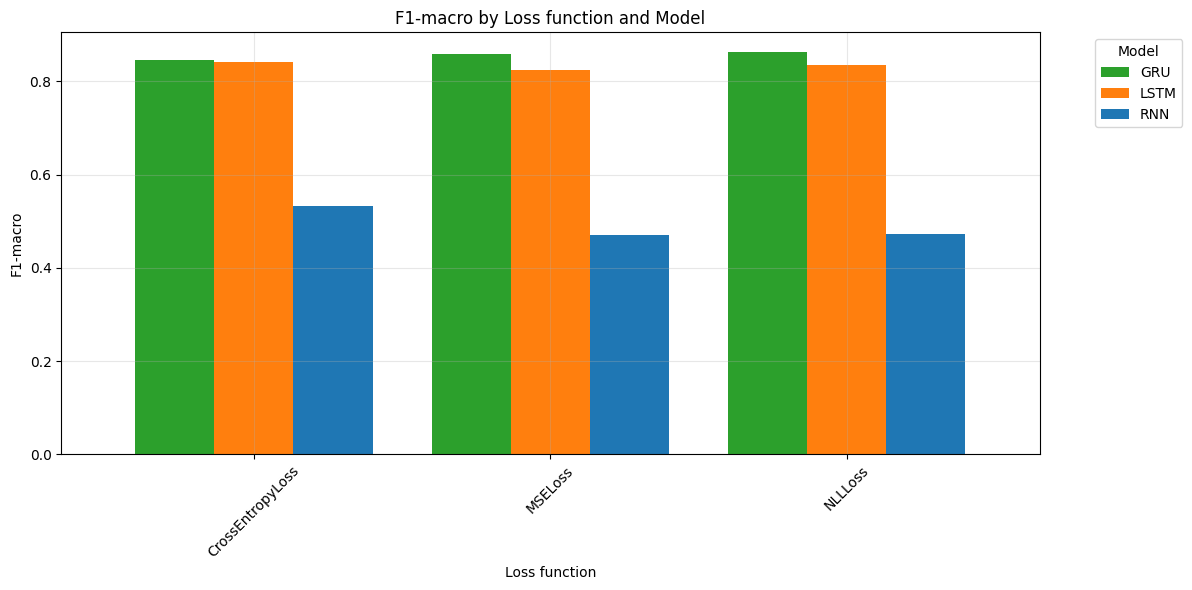


Detailed F1-macro Comparison by Loss function:
------------------------------------------------------------
Model                GRU    LSTM     RNN
Hyperparameter                          
CrossEntropyLoss  0.8453  0.8404  0.5322
MSELoss           0.8578  0.8249  0.4704
NLLLoss           0.8619  0.8345  0.4726


<Figure size 1200x600 with 0 Axes>

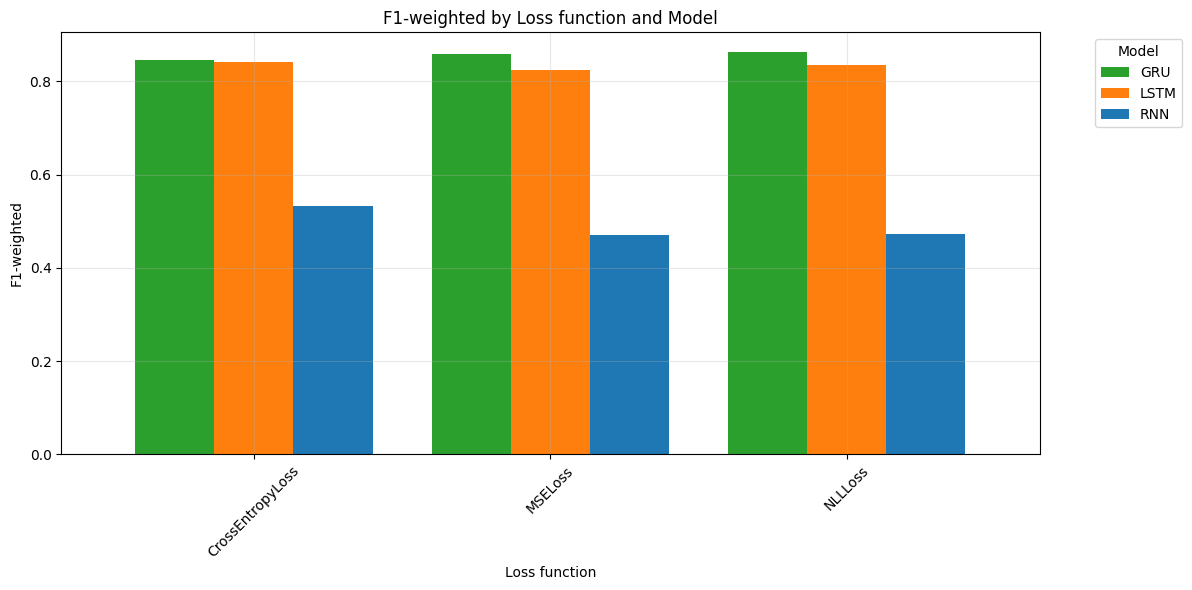


Detailed F1-weighted Comparison by Loss function:
------------------------------------------------------------
Model                GRU    LSTM     RNN
Hyperparameter                          
CrossEntropyLoss  0.8453  0.8404  0.5322
MSELoss           0.8578  0.8249  0.4704
NLLLoss           0.8619  0.8345  0.4726


,Model,Hyperparameter,Metric
0,RNN,CrossEntropyLoss,0.532224
1,LSTM,CrossEntropyLoss,0.840403
2,GRU,CrossEntropyLoss,0.845283
3,RNN,MSELoss,0.470420
4,LSTM,MSELoss,0.824902
5,GRU,MSELoss,0.857788
6,RNN,NLLLoss,0.472569
7,LSTM,NLLLoss,0.834505
8,GRU,NLLLoss,0.861901


In [35]:
plot_model_comparison_by_hp(loss_function_experiments, 'loss_function', metric='Accuracy')
plot_model_comparison_by_hp(loss_function_experiments, 'loss_function', metric='Precision')
plot_model_comparison_by_hp(loss_function_experiments, 'loss_function', metric='Recall')
plot_model_comparison_by_hp(loss_function_experiments, 'loss_function', metric='F1-micro')
plot_model_comparison_by_hp(loss_function_experiments, 'loss_function', metric='F1-macro')
plot_model_comparison_by_hp(loss_function_experiments, 'loss_function', metric='F1-weighted')


<Figure size 1200x600 with 0 Axes>

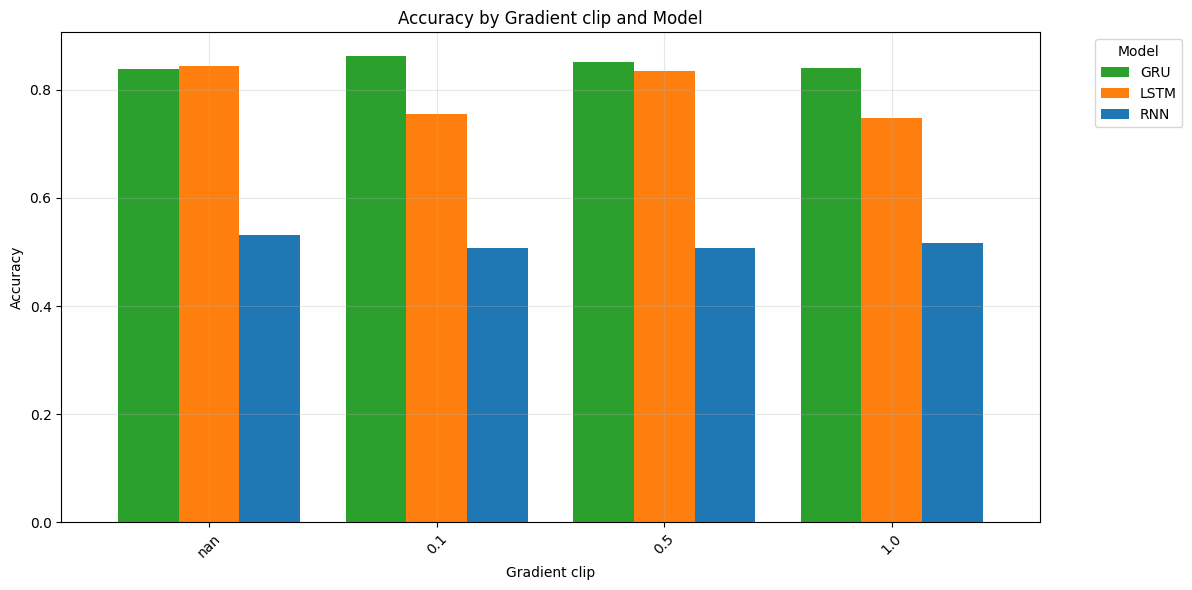


Detailed Accuracy Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8376  0.8432  0.5312
0.1             0.8631  0.7550  0.5073
0.5             0.8507  0.8353  0.5083
1.0             0.8406  0.7486  0.5163


<Figure size 1200x600 with 0 Axes>

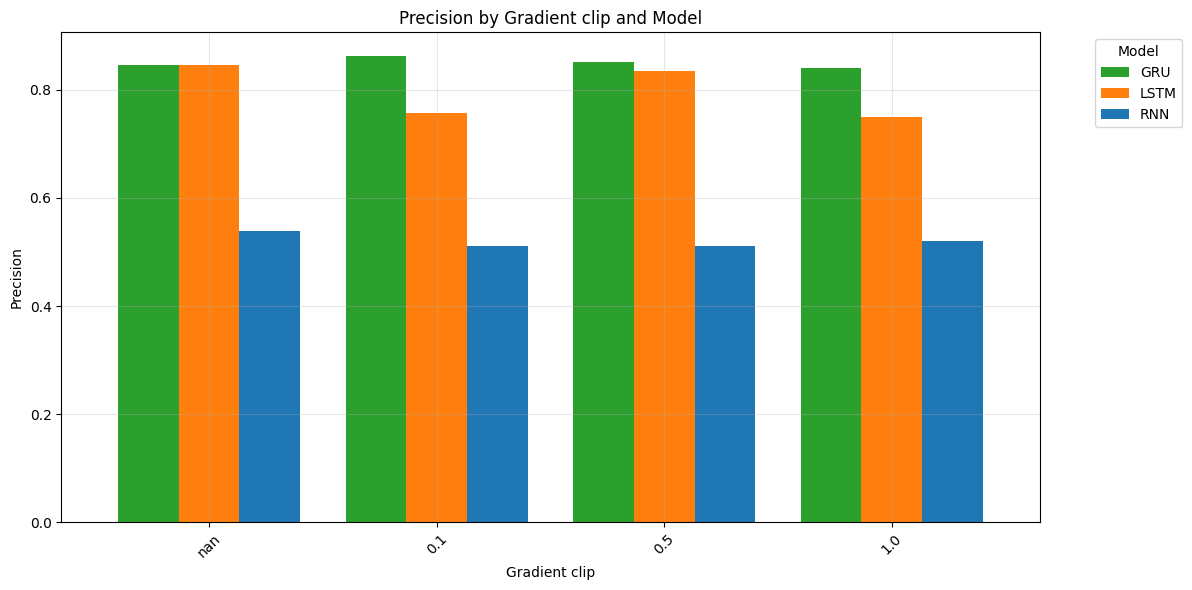


Detailed Precision Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8450  0.8450  0.5388
0.1             0.8631  0.7575  0.5118
0.5             0.8507  0.8355  0.5104
1.0             0.8409  0.7488  0.5198


<Figure size 1200x600 with 0 Axes>

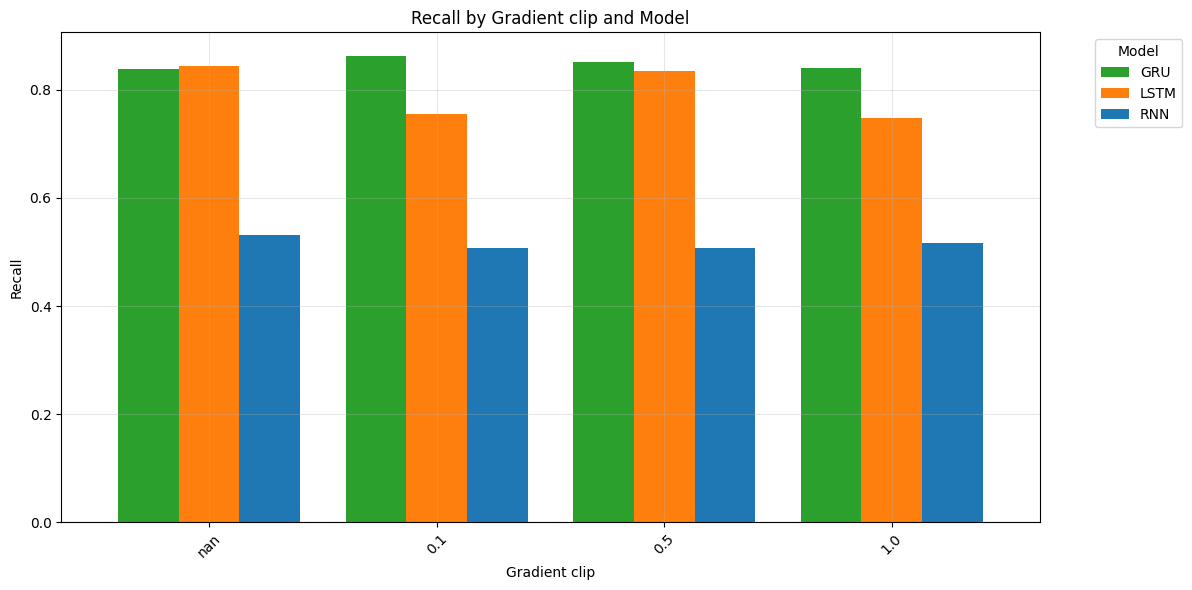


Detailed Recall Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8376  0.8432  0.5312
0.1             0.8631  0.7550  0.5073
0.5             0.8507  0.8353  0.5083
1.0             0.8406  0.7486  0.5163


<Figure size 1200x600 with 0 Axes>

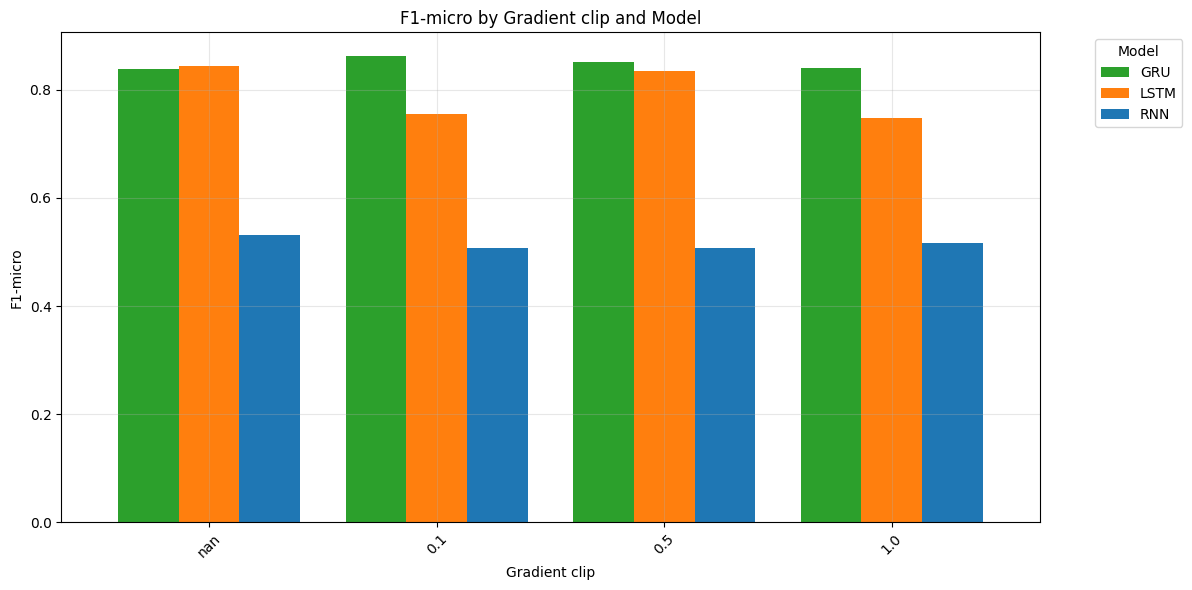


Detailed F1-micro Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8376  0.8432  0.5312
0.1             0.8631  0.7550  0.5073
0.5             0.8507  0.8353  0.5083
1.0             0.8406  0.7486  0.5163


<Figure size 1200x600 with 0 Axes>

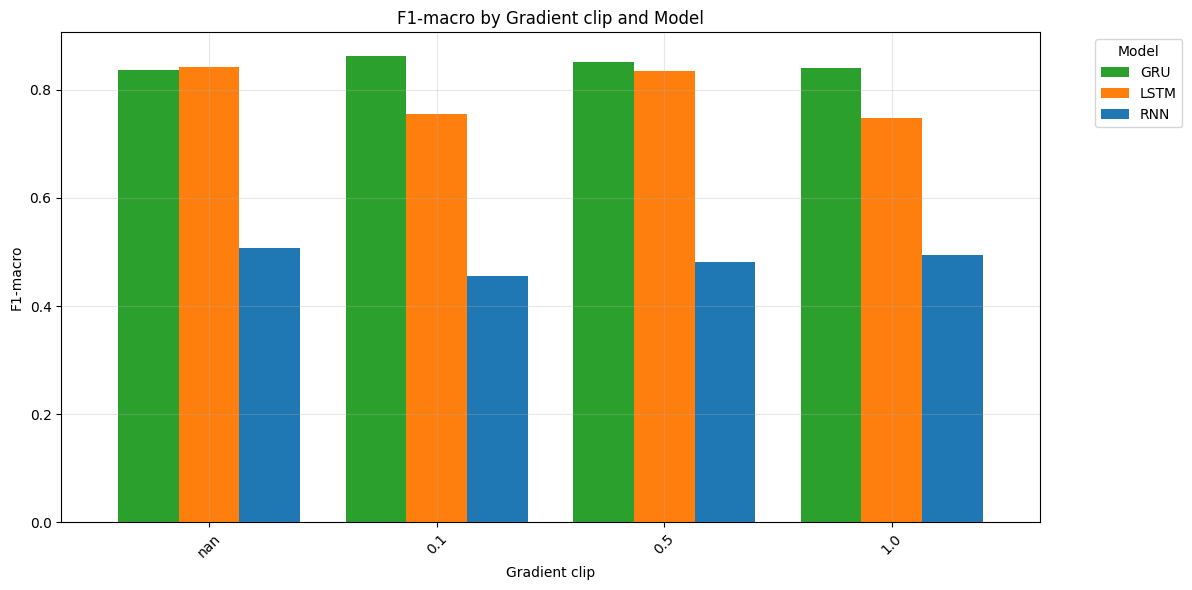


Detailed F1-macro Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8367  0.8430  0.5070
0.1             0.8631  0.7544  0.4553
0.5             0.8507  0.8353  0.4817
1.0             0.8406  0.7485  0.4940


<Figure size 1200x600 with 0 Axes>

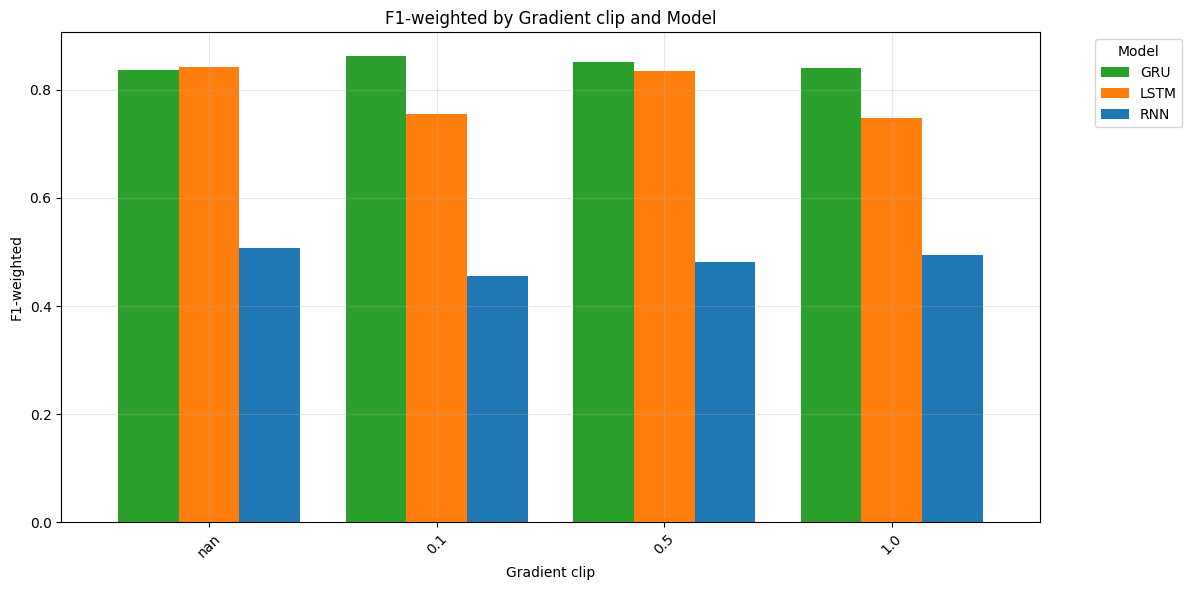


Detailed F1-weighted Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8367  0.8430  0.5070
0.1             0.8631  0.7544  0.4553
0.5             0.8507  0.8353  0.4817
1.0             0.8406  0.7485  0.4940


,Model,Hyperparameter,Metric
0,RNN,NaN,0.506990
1,LSTM,NaN,0.842990
2,GRU,NaN,0.836730
3,RNN,0.1,0.455253
4,LSTM,0.1,0.754401
5,GRU,0.1,0.863099
6,RNN,0.5,0.481661
7,LSTM,0.5,0.835270
8,GRU,0.5,0.850700
9,RNN,1.0,0.494007


In [36]:
plot_model_comparison_by_hp(gradient_clipping_value_test, 'gradient_clip', metric='Accuracy')
plot_model_comparison_by_hp(gradient_clipping_value_test, 'gradient_clip', metric='Precision')
plot_model_comparison_by_hp(gradient_clipping_value_test, 'gradient_clip', metric='Recall')
plot_model_comparison_by_hp(gradient_clipping_value_test, 'gradient_clip', metric='F1-micro')
plot_model_comparison_by_hp(gradient_clipping_value_test, 'gradient_clip', metric='F1-macro')
plot_model_comparison_by_hp(gradient_clipping_value_test, 'gradient_clip', metric='F1-weighted')

<Figure size 1200x600 with 0 Axes>

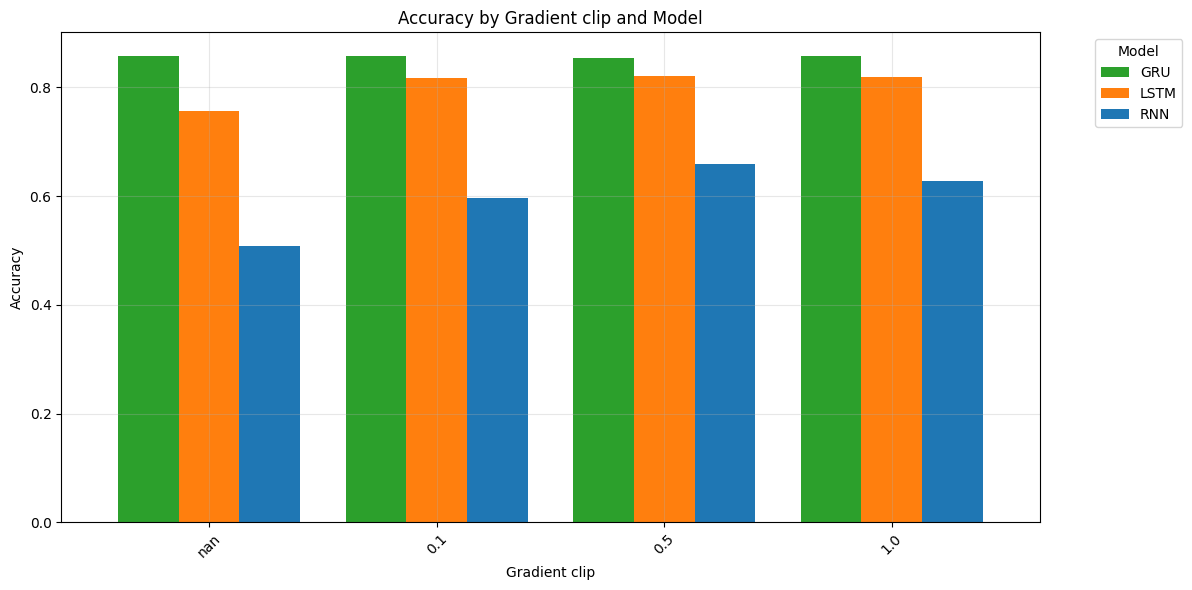


Detailed Accuracy Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8575  0.7566  0.5078
0.1             0.8585  0.8169  0.5960
0.5             0.8546  0.8218  0.6588
1.0             0.8584  0.8185  0.6282


<Figure size 1200x600 with 0 Axes>

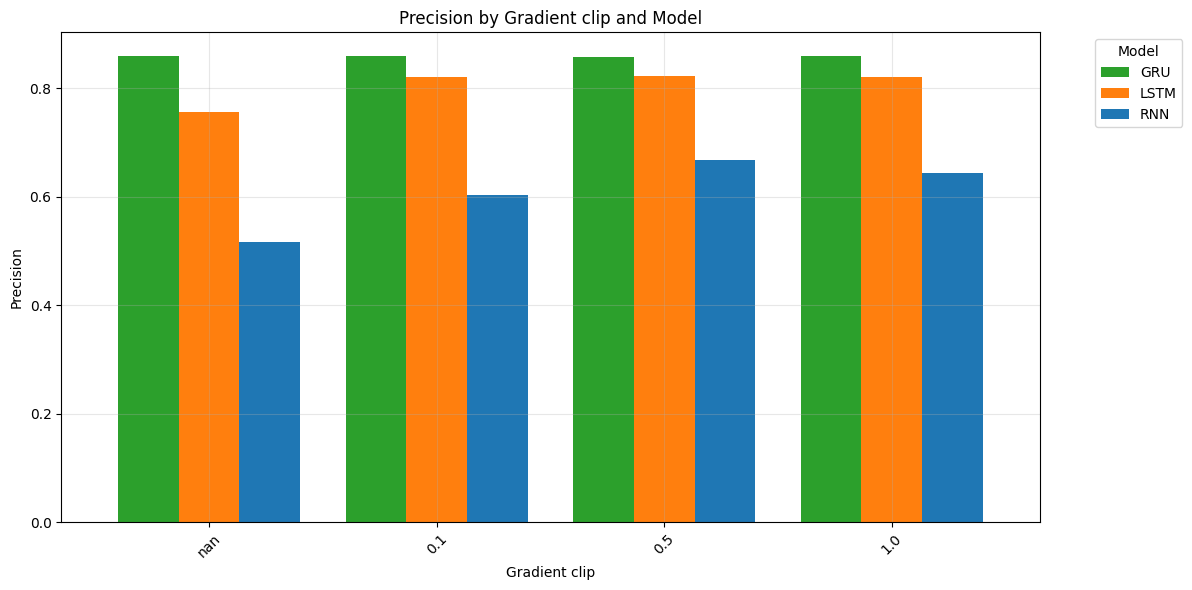


Detailed Precision Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8591  0.7566  0.5162
0.1             0.8599  0.8208  0.6035
0.5             0.8567  0.8224  0.6677
1.0             0.8586  0.8200  0.6430


<Figure size 1200x600 with 0 Axes>

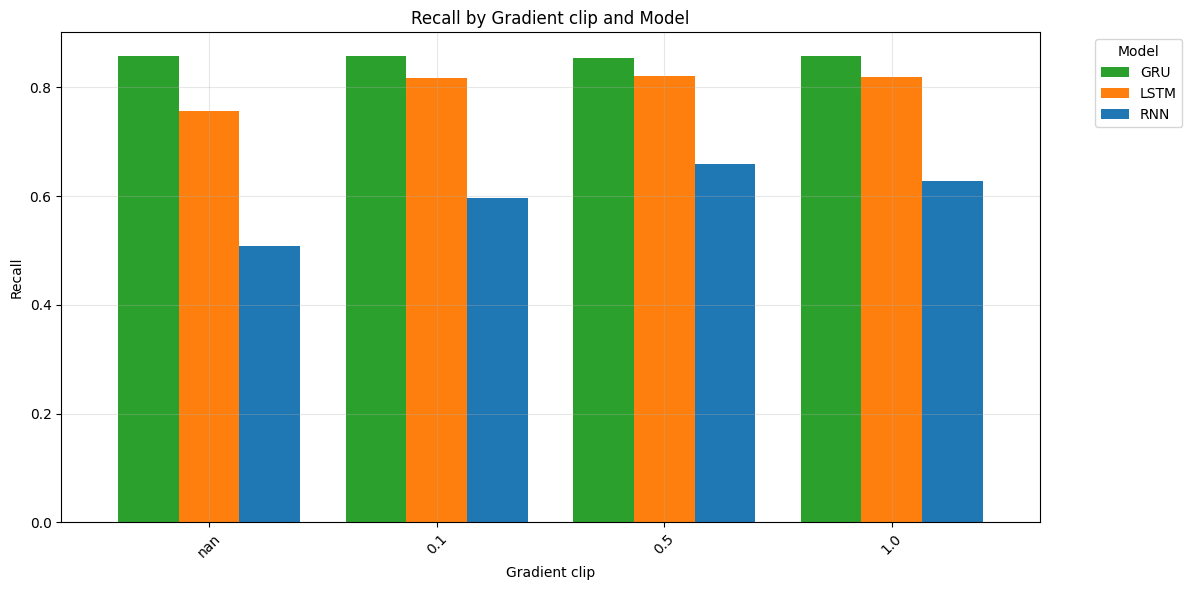


Detailed Recall Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8575  0.7566  0.5078
0.1             0.8585  0.8169  0.5960
0.5             0.8546  0.8218  0.6588
1.0             0.8584  0.8185  0.6282


<Figure size 1200x600 with 0 Axes>

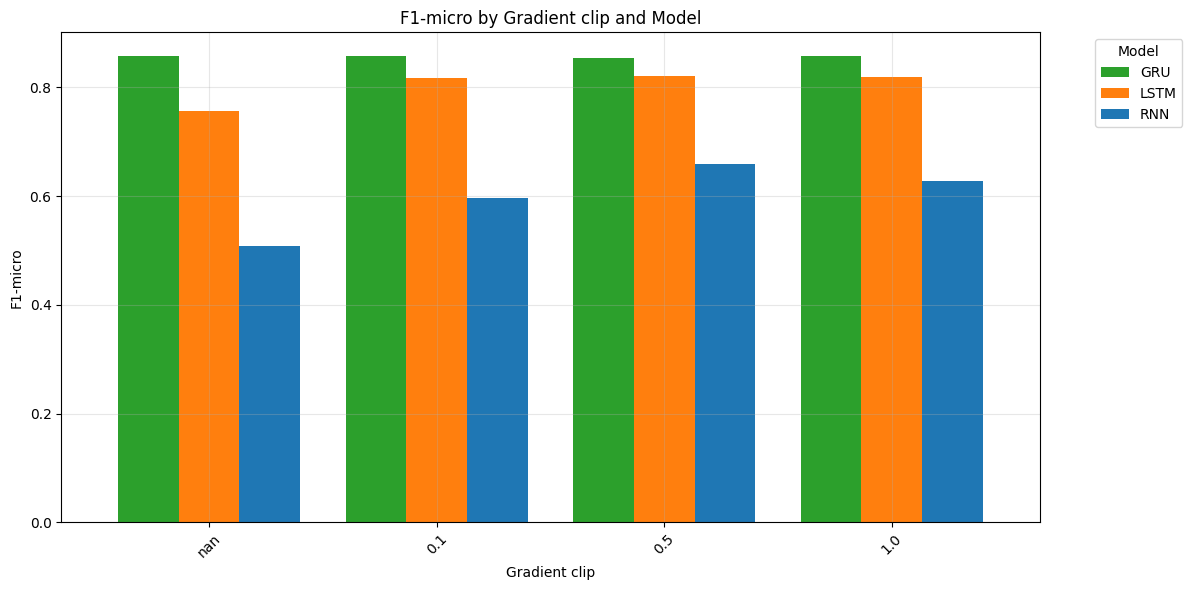


Detailed F1-micro Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8575  0.7566  0.5078
0.1             0.8585  0.8169  0.5960
0.5             0.8546  0.8218  0.6588
1.0             0.8584  0.8185  0.6282


<Figure size 1200x600 with 0 Axes>

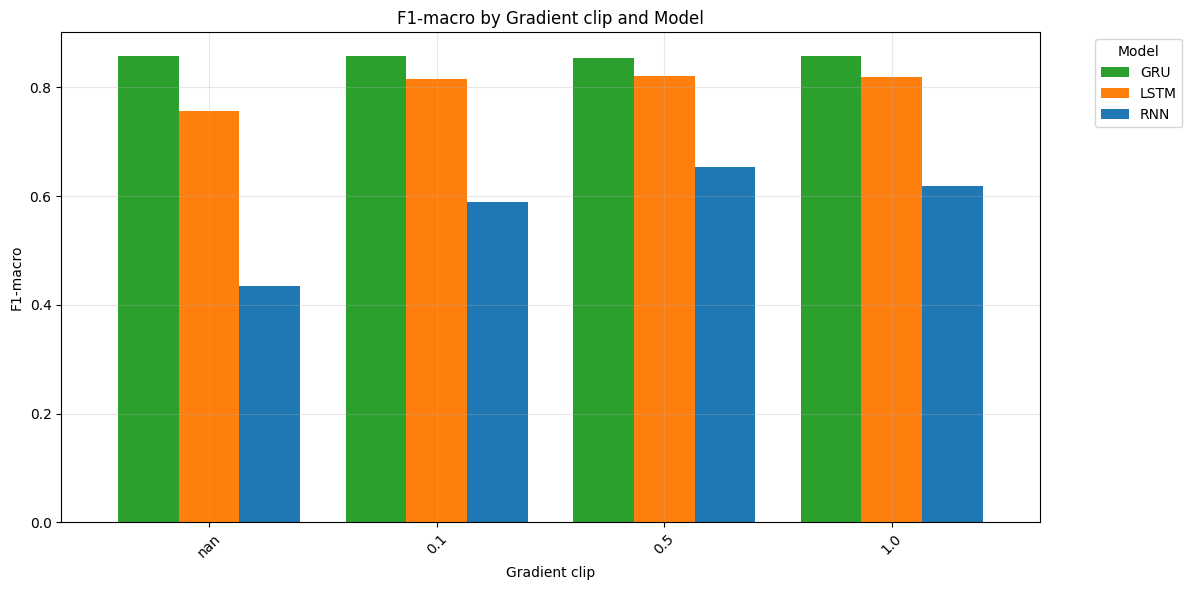


Detailed F1-macro Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8573  0.7566  0.4345
0.1             0.8584  0.8163  0.5886
0.5             0.8544  0.8217  0.6542
1.0             0.8584  0.8183  0.6183


<Figure size 1200x600 with 0 Axes>

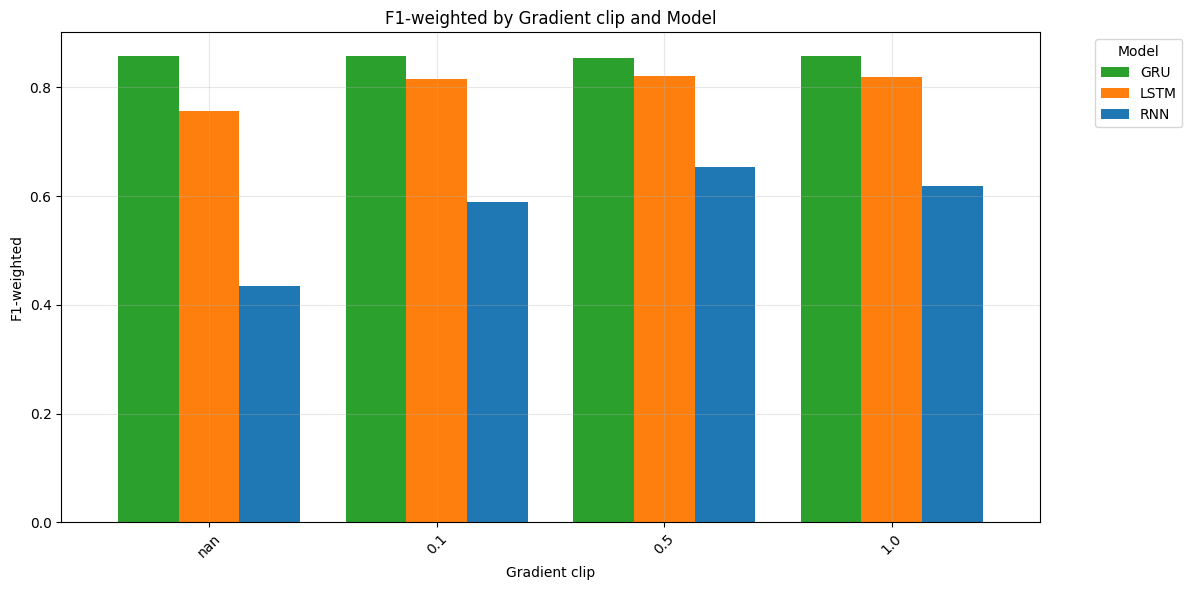


Detailed F1-weighted Comparison by Gradient clip:
------------------------------------------------------------
Model              GRU    LSTM     RNN
Hyperparameter                        
NaN             0.8573  0.7566  0.4345
0.1             0.8584  0.8163  0.5886
0.5             0.8544  0.8217  0.6542
1.0             0.8584  0.8183  0.6183


,Model,Hyperparameter,Metric
0,RNN,NaN,0.434513
1,LSTM,NaN,0.756594
2,GRU,NaN,0.857344
3,RNN,0.1,0.588591
4,LSTM,0.1,0.816342
5,GRU,0.1,0.858361
6,RNN,0.5,0.654195
7,LSTM,0.5,0.821714
8,GRU,0.5,0.854381
9,RNN,1.0,0.618331


In [37]:
plot_model_comparison_by_hp(gradient_clipping_norm_test, 'gradient_clip', metric='Accuracy')
plot_model_comparison_by_hp(gradient_clipping_norm_test, 'gradient_clip', metric='Precision')
plot_model_comparison_by_hp(gradient_clipping_norm_test, 'gradient_clip', metric='Recall')
plot_model_comparison_by_hp(gradient_clipping_norm_test, 'gradient_clip', metric='F1-micro')
plot_model_comparison_by_hp(gradient_clipping_norm_test, 'gradient_clip', metric='F1-macro')
plot_model_comparison_by_hp(gradient_clipping_norm_test, 'gradient_clip', metric='F1-weighted')
